# Varying Noise Experiment
In this notebook, we test our algorithm in setting where there is a lot of noise variance. We then compare our results to other methods on the same task.

In [33]:
import sys 
sys.path.append('../..')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython 

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [31]:
args = Parameters({
    "samples": 1000, # number of samples to generate for ground-truth
    "c": 0,
    "bs": 10,
    "lr": 1e-1,
    'var_lr': 1e-1,
    "trials": 10,
    "steps": 5000,
    "x_lower": -10,  # lower bound for generating input features
    "x_upper": 10,  # upper bound for generating input features
    "lower": -1, # lower bound for generating ground-truth
    "upper": 1, # lower bound for generating ground-truth
    'out_dir': '<FILL IN OUT_DIR HERE>' 
    'exp': '<FILL IN EXP HERE>', 
    'eps': 1e-5,
    'var': 5,  # maximum variance to use in procedure
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'n': 100,
    'attempts': 3,
    'val': .1,
})

I will first begin, by showing how to use our algorithm in a 1 dimensional setting. I will sample input features from a Uniform distribution, I will also sample my ground-truth from a Uniform distribution, and I will add Gaussian noise with noise variance 10.

gt weight:  Parameter containing:
tensor([[0.9530]], requires_grad=True)
gt bias:  None
alpha:  tensor([0.5390])
gt ols coef:  [[0.9518201]]
gt ols intercept:  [0.32073814]
trunc ols coef:  [[0.63053405]]
trunc ols intercept:  [2.6624804]


Text(0, 0.5, 'y')

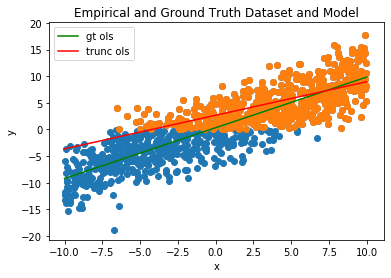

In [16]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(args.lower, args.upper)
m = Uniform(args.x_lower, args.x_upper)
phi = oracle.Left(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([10.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-args.x_lower, args.x_upper, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to normalize our input features dataset. So, we divide all of our covariate features by $B\sqrt{k}$, so that $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. By doing this, the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [17]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(9.9555)
beta:  tensor(9.9555)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([7.5479])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

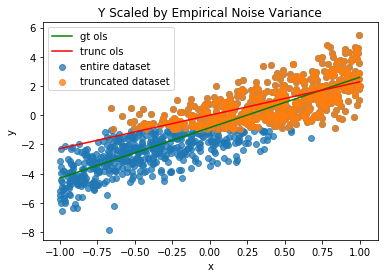

In [18]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.7548])
reg noise var:  tensor([0.9987])


Text(0, 0.5, 'y')

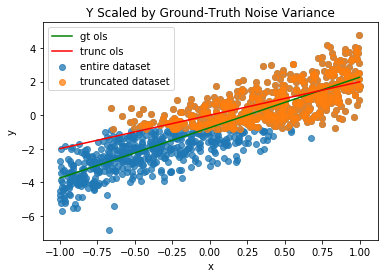

In [19]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

We will now run our procedure for truncated regression with known variance, assuming that the empirical noise variance is the actual noisie variance. Since we applied feature transformations to our truncated dataset, we now need to reverse the trnasformations after the compeltion of our procedure.

In [20]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.12589602172374725
Iteration 2 | Score: 0.1491381824016571
Iteration 3 | Score: 0.16700264811515808
Iteration 4 | Score: 0.10207580029964447
Iteration 5 | Score: 0.14063407480716705
Iteration 6 | Score: 0.13389644026756287
Iteration 7 | Score: 0.14419318735599518
Iteration 8 | Score: 0.16562703251838684
Iteration 9 | Score: 0.17754794657230377
Iteration 10 | Score: 0.18602284789085388
Iteration 11 | Score: 0.15281368792057037
Iteration 12 | Score: 0.13522794842720032
Iteration 13 | Score: 0.15522505342960358
Iteration 14 | Score: 0.17177826166152954
Iteration 15 | Score: 0.14811399579048157
Iteration 16 | Score: 0.16569018363952637
Iteration 17 | Score: 0.1689084768295288
Iteration 18 | Score: 0.15754802525043488
Iteration 19 | Score: 0.17535686492919922
Iteration 20 | Score: 0.1564319133758545
Iteration 21 | Score: 0.17044803500175476
Iteration 22 | Score: 0.18492698669433594
Iteration 23 | Score: 0.17320455610752106
Iteration 24 | Score: 0.1721079796552658
Itera

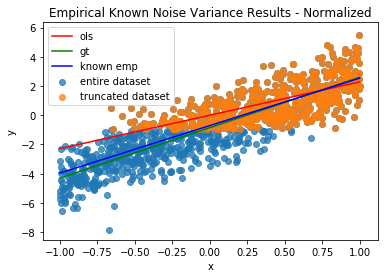

Text(0, 0.5, 'y')

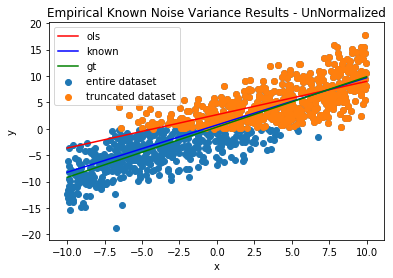

In [21]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [22]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-3, steps=5000, step_lr_gamma=1.0)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.031837742775678635
Iteration 2 | Score: 0.0132511667907238
Iteration 3 | Score: 0.0497555136680603
Iteration 4 | Score: 0.0540073923766613
Iteration 5 | Score: 0.010361161082983017
Iteration 6 | Score: 0.01796545460820198
Iteration 7 | Score: 0.05258641391992569
Iteration 8 | Score: 0.004503291100263596
Iteration 9 | Score: 0.053836118429899216
Iteration 10 | Score: 0.03690014034509659
Iteration 11 | Score: 0.05368219316005707
Iteration 12 | Score: 0.021466340869665146
Iteration 13 | Score: 0.007487442344427109
Iteration 14 | Score: 0.06855753064155579
Iteration 15 | Score: 0.015738874673843384
Iteration 16 | Score: 0.013456020504236221
Iteration 17 | Score: 0.016781046986579895
Iteration 18 | Score: 0.0017498321831226349
Iteration 19 | Score: 0.019406739622354507
Iteration 20 | Score: 0.07791213691234589
Iteration 21 | Score: 0.028088029474020004
Iteration 22 | Score: 0.03340233117341995
Iteration 23 | Score: 0.014051064848899841
Final Score: 7.051974534988403e-

ValueError: x and y must be the same size

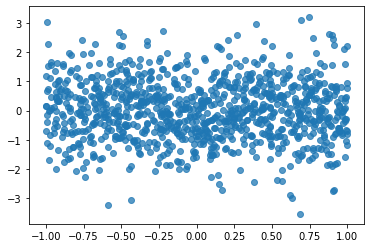

In [34]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [46]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000, step_lr_gamma=1.0)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.19935822486877441
Iteration: 1.0 | Score: 0.13923092186450958
Iteration: 2.0 | Score: 0.10559302568435669
Iteration: 3.0 | Score: 0.10563316941261292
Iteration: 4.0 | Score: 0.08363194018602371
Iteration: 5.0 | Score: 0.09220293164253235
Iteration: 6.0 | Score: 0.1387084722518921
Iteration: 7.0 | Score: 0.041503604501485825
Iteration: 8.0 | Score: 0.21274176239967346
Iteration: 9.0 | Score: 0.163943812251091
Iteration: 10.0 | Score: 0.1934526264667511
Iteration: 11.0 | Score: 0.22898326814174652
Iteration: 12.0 | Score: 0.2433662861585617
Iteration: 13.0 | Score: 0.20433394610881805
Iteration: 14.0 | Score: 0.11090316623449326
Iteration: 15.0 | Score: 0.09378673881292343
Iteration: 16.0 | Score: 0.09576207399368286
Iteration: 17.0 | Score: 0.08441003412008286
Iteration: 18.0 | Score: 0.14254021644592285
Iteration: 19.0 | Score: 0.14438937604427338
Iteration: 20.0 | Score: 0.07567647099494934


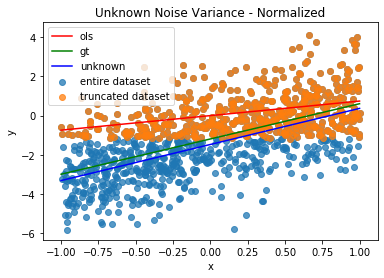

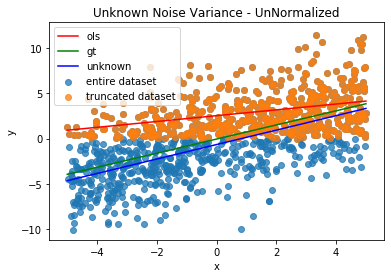

In [47]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [24]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

# Generate Ground-Truth and Run Experiment

In [25]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

In [32]:
for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + '/' + args.exp)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'trunc_reg_r2': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_mse': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(args.val*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        emp_stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        known_emp_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(noise_var))
    
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0]).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'var_lr': args.var_lr,
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0]).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /Users/patroklos/Regression/VarTest/ce88313b-6e51-4087-9bfe-36ee3ffadb2d
Iteration 1 | Score: 0.15341272950172424
Iteration 2 | Score: 0.05766429007053375
Iteration 3 | Score: 0.03163374960422516
Iteration 4 | Score: 0.1074104756116867
Iteration 5 | Score: 0.13309377431869507
Iteration 6 | Score: 0.0485677495598793
Iteration 7 | Score: 0.09518609941005707
Iteration 8 | Score: 0.0675181895494461
Iteration 9 | Score: 0.12972968816757202
Iteration 10 | Score: 0.11810749769210815
Iteration 11 | Score: 0.07453657686710358
Iteration 12 | Score: 0.07748818397521973
Iteration 13 | Score: 0.0978492796421051
Iteration 14 | Score: 0.1368509978055954
Iteration 15 | Score: 0.05980454385280609
Iteration 16 | Score: 0.0761890858411789
Iteration 17 | Score: 0.09202137589454651
Iteration 18 | Score: 0.13864493370056152
Iteration 19 | Score: 0.11286917328834534
Iteration 20 | Score: 0.059185706079006195
Iteration 21 | Score: 0.08191026747226715
Iteration 22 | Score: 0.12795022130012512
Itera

Iteration 37 | Score: 0.14629797637462616
Iteration 38 | Score: 0.12821626663208008
Iteration 39 | Score: 0.14075002074241638
Iteration 40 | Score: 0.14129790663719177
Iteration 41 | Score: 0.08615577220916748
Iteration 42 | Score: 0.13432948291301727
Iteration 43 | Score: 0.12528131902217865
Iteration 44 | Score: 0.18127493560314178
Iteration 45 | Score: 0.13832612335681915
Iteration 46 | Score: 0.09733536094427109
Iteration 47 | Score: 0.1525166630744934
Iteration 48 | Score: 0.11123692244291306
Iteration 49 | Score: 0.08184511959552765
Iteration 50 | Score: 0.1756359040737152
Iteration 1 | Score: 0.4261201024055481
Iteration 2 | Score: 0.3869985342025757
Iteration 3 | Score: 0.34698954224586487
Iteration 4 | Score: 0.2649034261703491
Iteration 5 | Score: 0.25512072443962097
Iteration 6 | Score: 0.18316058814525604
Iteration 7 | Score: 0.3528958857059479
Iteration 8 | Score: 0.14521203935146332
Iteration 9 | Score: 0.23469814658164978
Iteration 10 | Score: 0.3837062418460846
Iteratio

Iteration 24 | Score: 0.047941070050001144
Iteration 25 | Score: 0.04570600390434265
Iteration 26 | Score: 0.029965071007609367
Iteration 27 | Score: 0.038269903510808945
Iteration 28 | Score: 0.03779962286353111
Iteration 29 | Score: 0.030991293489933014
Iteration 30 | Score: 0.013377026654779911
Iteration 31 | Score: 0.05001584812998772
Final Score: 0.007051624823361635
Iteration 1 | Score: 0.1409921497106552
Iteration 2 | Score: 0.018179696053266525
Iteration 3 | Score: 0.11081159859895706
Iteration 4 | Score: 0.032350391149520874
Iteration 5 | Score: 0.08498837053775787
Iteration 6 | Score: 0.0589447058737278
Iteration 7 | Score: 0.08480513095855713
Iteration 8 | Score: 0.15336202085018158
Iteration 9 | Score: 0.051840901374816895
Iteration 10 | Score: 0.15945032238960266
Iteration 11 | Score: 0.01666385866701603
Iteration 12 | Score: 0.09408452361822128
Iteration 13 | Score: 0.06531435996294022
Iteration 14 | Score: 0.10661396384239197
Iteration 15 | Score: 0.06593411415815353
Ite

Iteration 41 | Score: 0.0975121408700943
Iteration 42 | Score: 0.11014144122600555
Iteration 43 | Score: 0.10209690034389496
Iteration 44 | Score: 0.07319325953722
Iteration 45 | Score: 0.11477857828140259
Iteration 46 | Score: 0.10412202775478363
Iteration 47 | Score: 0.10913797467947006
Iteration 48 | Score: 0.09134674072265625
Iteration 49 | Score: 0.0936475321650505
Iteration 50 | Score: 0.11324389278888702
Iteration 1 | Score: 0.08174049854278564
Iteration 2 | Score: 0.07554984092712402
Iteration 3 | Score: 0.07411584258079529
Iteration 4 | Score: 0.062308743596076965
Iteration 5 | Score: 0.06316138058900833
Iteration 6 | Score: 0.07080844044685364
Iteration 7 | Score: 0.07651227712631226
Iteration 8 | Score: 0.07318058609962463
Iteration 9 | Score: 0.062911257147789
Iteration 10 | Score: 0.07827892899513245
Iteration 11 | Score: 0.07714433968067169
Iteration 12 | Score: 0.0749264732003212
Iteration 13 | Score: 0.07301259785890579
Iteration 14 | Score: 0.07023706287145615
Iteratio

Iteration 33 | Score: 0.1195068359375
Iteration 34 | Score: 0.10867501050233841
Iteration 35 | Score: 0.08180555701255798
Iteration 36 | Score: 0.024710968136787415
Iteration 37 | Score: 0.10182063281536102
Iteration 38 | Score: 0.12742061913013458
Iteration 39 | Score: 0.10154616832733154
Iteration 40 | Score: 0.13155017793178558
Iteration 41 | Score: 0.058840177953243256
Iteration 42 | Score: 0.12241420149803162
Iteration 43 | Score: 0.10395338386297226
Iteration 44 | Score: 0.10401984304189682
Iteration 45 | Score: 0.07164205610752106
Iteration 46 | Score: 0.0668380856513977
Iteration 47 | Score: 0.1335671991109848
Iteration 48 | Score: 0.058589961379766464
Iteration 49 | Score: 0.10305220633745193
Iteration 50 | Score: 0.06628645956516266
Iteration 1 | Score: 0.2388828843832016
Iteration 2 | Score: 0.20664910972118378
Iteration 3 | Score: 0.3047839403152466
Iteration 4 | Score: 0.0722087025642395
Iteration 5 | Score: 0.298893004655838
Iteration 6 | Score: 0.17129720747470856
Iterat

Iteration 33 | Score: 0.11270612478256226
Iteration 34 | Score: 0.11025797575712204
Iteration 35 | Score: 0.131516695022583
Iteration 36 | Score: 0.12872307002544403
Iteration 37 | Score: 0.12241500616073608
Iteration 38 | Score: 0.11541448533535004
Iteration 39 | Score: 0.12263962626457214
Iteration 40 | Score: 0.13138261437416077
Iteration 41 | Score: 0.11505429446697235
Iteration 42 | Score: 0.11672041565179825
Iteration 43 | Score: 0.12490881979465485
Iteration 44 | Score: 0.10214418917894363
Iteration 45 | Score: 0.13415169715881348
Iteration 46 | Score: 0.1316286325454712
Iteration 47 | Score: 0.1283029019832611
Iteration 48 | Score: 0.12254612147808075
Iteration 49 | Score: 0.1134297251701355
Iteration 50 | Score: 0.12598761916160583
Iteration 1 | Score: 0.0818992331624031
Iteration 2 | Score: 0.11204025149345398
Iteration 3 | Score: 0.11310406774282455
Iteration 4 | Score: 0.13872449100017548
Iteration 5 | Score: 0.08009327948093414
Iteration 6 | Score: 0.11025162041187286
Iter

Iteration 30 | Score: 0.35955318808555603
Iteration 31 | Score: 0.3321455717086792
Iteration 32 | Score: 0.3299355208873749
Iteration 33 | Score: 0.4842657446861267
Iteration 34 | Score: 0.3239073157310486
Iteration 35 | Score: 0.38952553272247314
Iteration 36 | Score: 0.4064640998840332
Iteration 37 | Score: 0.43662166595458984
Iteration 38 | Score: 0.24038518965244293
Iteration 39 | Score: 0.31432822346687317
Iteration 40 | Score: 0.35505032539367676
Iteration 41 | Score: 0.3788806200027466
Iteration 42 | Score: 0.4425172805786133
Iteration 43 | Score: 0.3099420666694641
Iteration 44 | Score: 0.3906450569629669
Iteration 45 | Score: 0.4023524820804596
Iteration 46 | Score: 0.43486955761909485
Iteration 47 | Score: 0.2978242039680481
Iteration 48 | Score: 0.3646164834499359
Iteration 49 | Score: 0.3335616886615753
Iteration 50 | Score: 0.33826562762260437
Iteration 1 | Score: 0.06000984087586403
Iteration 2 | Score: 0.17251765727996826
Iteration 3 | Score: 0.14615745842456818
Iteratio

Iteration 31 | Score: 0.18081194162368774
Iteration 32 | Score: 0.1674209088087082
Iteration 33 | Score: 0.2012217789888382
Iteration 34 | Score: 0.19237381219863892
Iteration 35 | Score: 0.18431934714317322
Iteration 36 | Score: 0.1984967440366745
Iteration 37 | Score: 0.18854095041751862
Iteration 38 | Score: 0.17193011939525604
Iteration 39 | Score: 0.17782263457775116
Iteration 40 | Score: 0.18878701329231262
Iteration 41 | Score: 0.1778491586446762
Iteration 42 | Score: 0.16440093517303467
Iteration 43 | Score: 0.1881609559059143
Iteration 44 | Score: 0.20025844871997833
Iteration 45 | Score: 0.1935296207666397
Iteration 46 | Score: 0.18431757390499115
Iteration 47 | Score: 0.1864011287689209
Iteration 48 | Score: 0.1883559226989746
Iteration 49 | Score: 0.20197942852973938
Iteration 50 | Score: 0.1858726441860199
Iteration 1 | Score: 0.10591565072536469
Iteration 2 | Score: 0.21698084473609924
Iteration 3 | Score: 0.2006937861442566
Iteration 4 | Score: 0.2657695710659027
Iterati

Iteration 28 | Score: 0.20609676837921143
Iteration 29 | Score: 0.22671888768672943
Iteration 30 | Score: 0.20539936423301697
Iteration 31 | Score: 0.17355847358703613
Iteration 32 | Score: 0.2017151564359665
Iteration 33 | Score: 0.16023306548595428
Iteration 34 | Score: 0.20488546788692474
Iteration 35 | Score: 0.20449933409690857
Iteration 36 | Score: 0.16955602169036865
Iteration 37 | Score: 0.19553540647029877
Iteration 38 | Score: 0.16056646406650543
Iteration 39 | Score: 0.18993906676769257
Iteration 40 | Score: 0.17260776460170746
Iteration 41 | Score: 0.22066956758499146
Iteration 42 | Score: 0.1974320262670517
Iteration 43 | Score: 0.19491326808929443
Iteration 44 | Score: 0.19010710716247559
Iteration 45 | Score: 0.1906261444091797
Iteration 46 | Score: 0.17905698716640472
Iteration 47 | Score: 0.1925785392522812
Iteration 48 | Score: 0.21173833310604095
Iteration 49 | Score: 0.22238388657569885
Iteration 50 | Score: 0.22445394098758698
Iteration 1 | Score: 0.357776731252670

Iteration 27 | Score: 0.054457880556583405
Iteration 28 | Score: 0.04648081958293915
Iteration 29 | Score: 0.05909057334065437
Iteration 30 | Score: 0.056794553995132446
Iteration 31 | Score: 0.04769899323582649
Iteration 32 | Score: 0.029663708060979843
Iteration 33 | Score: 0.025782134383916855
Iteration 34 | Score: 0.03466910496354103
Iteration 35 | Score: 0.04580168426036835
Iteration 36 | Score: 0.03688451275229454
Iteration 37 | Score: 0.042484357953071594
Iteration 38 | Score: 0.04644690826535225
Iteration 39 | Score: 0.05058906599879265
Iteration 40 | Score: 0.0700925886631012
Iteration 41 | Score: 0.039567410945892334
Iteration 42 | Score: 0.034681838005781174
Iteration 43 | Score: 0.026788379997015
Iteration 44 | Score: 0.03236151486635208
Iteration 45 | Score: 0.03655993565917015
Iteration 46 | Score: 0.04110296070575714
Iteration 47 | Score: 0.03010132722556591
Iteration 48 | Score: 0.053168054670095444
Iteration 49 | Score: 0.014775875955820084
Iteration 50 | Score: 0.0260

Iteration 23 | Score: 0.06735529750585556
Iteration 24 | Score: 0.03103102371096611
Iteration 25 | Score: 0.08944184333086014
Iteration 26 | Score: 0.0613987073302269
Iteration 27 | Score: 0.04804426059126854
Iteration 28 | Score: 0.05116032436490059
Iteration 29 | Score: 0.04047821834683418
Iteration 30 | Score: 0.0708487406373024
Iteration 31 | Score: 0.03469998389482498
Iteration 32 | Score: 0.06568888574838638
Iteration 33 | Score: 0.0863150805234909
Iteration 34 | Score: 0.04788753390312195
Iteration 35 | Score: 0.05013832077383995
Iteration 36 | Score: 0.03272373229265213
Iteration 37 | Score: 0.03856589272618294
Iteration 38 | Score: 0.0730506032705307
Iteration 39 | Score: 0.04687526822090149
Iteration 40 | Score: 0.07478473335504532
Iteration 41 | Score: 0.06659667193889618
Iteration 42 | Score: 0.03789418935775757
Iteration 43 | Score: 0.0649304986000061
Iteration 44 | Score: 0.026733744889497757
Iteration 45 | Score: 0.05346491187810898
Iteration 46 | Score: 0.04128106310963

Iteration 21 | Score: 0.09660998731851578
Iteration 22 | Score: 0.07748518139123917
Iteration 23 | Score: 0.07483918219804764
Iteration 24 | Score: 0.06374578922986984
Iteration 25 | Score: 0.07661443203687668
Iteration 26 | Score: 0.08910908550024033
Iteration 27 | Score: 0.11429470032453537
Iteration 28 | Score: 0.08730385452508926
Iteration 29 | Score: 0.10727023333311081
Iteration 30 | Score: 0.07860106229782104
Iteration 31 | Score: 0.08150754868984222
Iteration 32 | Score: 0.0767432227730751
Iteration 33 | Score: 0.08177589625120163
Iteration 34 | Score: 0.07000988721847534
Iteration 35 | Score: 0.08503292500972748
Iteration 36 | Score: 0.07024041563272476
Iteration 37 | Score: 0.08379743993282318
Iteration 38 | Score: 0.06977208703756332
Iteration 39 | Score: 0.0822647362947464
Iteration 40 | Score: 0.07074403762817383
Iteration 41 | Score: 0.06318581104278564
Iteration 42 | Score: 0.0829254537820816
Iteration 43 | Score: 0.07470385730266571
Iteration 44 | Score: 0.1060277074575

Iteration 19 | Score: 0.40322214365005493
Iteration 20 | Score: 0.3711434304714203
Iteration 21 | Score: 0.3348843455314636
Iteration 22 | Score: 0.3754671812057495
Iteration 23 | Score: 0.45497626066207886
Iteration 24 | Score: 0.4741727113723755
Iteration 25 | Score: 0.3881955146789551
Iteration 26 | Score: 0.4550175070762634
Iteration 27 | Score: 0.44230547547340393
Iteration 28 | Score: 0.3314264416694641
Iteration 29 | Score: 0.36646732687950134
Iteration 30 | Score: 0.37648382782936096
Iteration 31 | Score: 0.4478611350059509
Iteration 32 | Score: 0.47814682126045227
Iteration 33 | Score: 0.3769165277481079
Iteration 34 | Score: 0.44707295298576355
Iteration 35 | Score: 0.388635516166687
Iteration 36 | Score: 0.3409317135810852
Iteration 37 | Score: 0.3680914044380188
Iteration 38 | Score: 0.4146023988723755
Iteration 39 | Score: 0.5002754926681519
Iteration 40 | Score: 0.4004020392894745
Iteration 41 | Score: 0.3683631122112274
Iteration 42 | Score: 0.38853928446769714
Iteration

Iteration 5 | Score: 0.14352531731128693
Iteration 6 | Score: 0.07696040719747543
Iteration 7 | Score: 0.13322265446186066
Iteration 8 | Score: 0.14958159625530243
Iteration 9 | Score: 0.19604606926441193
Iteration 10 | Score: 0.06819071620702744
Iteration 11 | Score: 0.044680289924144745
Iteration 12 | Score: 0.17233045399188995
Iteration 13 | Score: 0.1993599534034729
Iteration 14 | Score: 0.06566371768712997
Iteration 15 | Score: 0.1927698403596878
Iteration 16 | Score: 0.1395527422428131
Iteration 17 | Score: 0.2557729184627533
Iteration 18 | Score: 0.0511133037507534
Iteration 19 | Score: 0.06094636395573616
Iteration 20 | Score: 0.1509304791688919
Iteration 21 | Score: 0.16733959317207336
Iteration 22 | Score: 0.012275471352040768
Iteration 23 | Score: 0.16104039549827576
Iteration 24 | Score: 0.10697706788778305
Iteration 25 | Score: 0.25496676564216614
Iteration 26 | Score: 0.1326068937778473
Iteration 27 | Score: 0.08969123661518097
Iteration 28 | Score: 0.0976051390171051
Ite

Iteration 6 | Score: 0.09456339478492737
Iteration 7 | Score: 0.11230456829071045
Iteration 8 | Score: 0.13536956906318665
Iteration 9 | Score: 0.08488611876964569
Iteration 10 | Score: 0.0658767819404602
Iteration 11 | Score: 0.08605684340000153
Iteration 12 | Score: 0.11636566370725632
Iteration 13 | Score: 0.08351927995681763
Iteration 14 | Score: 0.06608949601650238
Iteration 15 | Score: 0.0947781503200531
Iteration 16 | Score: 0.11913296580314636
Iteration 17 | Score: 0.09225662797689438
Iteration 18 | Score: 0.10161170363426208
Iteration 19 | Score: 0.09159503877162933
Iteration 20 | Score: 0.1045198142528534
Iteration 21 | Score: 0.05433090031147003
Iteration 22 | Score: 0.08758841454982758
Iteration 23 | Score: 0.11392798274755478
Iteration 24 | Score: 0.09597474336624146
Iteration 25 | Score: 0.0896797776222229
Iteration 26 | Score: 0.07358264178037643
Iteration 27 | Score: 0.10565252602100372
Iteration 28 | Score: 0.09818607568740845
Iteration 29 | Score: 0.10696767270565033


Iteration 2 | Score: 0.1689147800207138
Iteration 3 | Score: 0.2353457659482956
Iteration 4 | Score: 0.19452866911888123
Iteration 5 | Score: 0.2443598061800003
Iteration 6 | Score: 0.26048776507377625
Iteration 7 | Score: 0.14156882464885712
Iteration 8 | Score: 0.1657920628786087
Iteration 9 | Score: 0.20500920712947845
Iteration 10 | Score: 0.1647787094116211
Iteration 11 | Score: 0.24950219690799713
Iteration 12 | Score: 0.2008197009563446
Iteration 13 | Score: 0.22048261761665344
Iteration 14 | Score: 0.21313174068927765
Iteration 15 | Score: 0.1676614135503769
Iteration 16 | Score: 0.16835570335388184
Iteration 17 | Score: 0.1825243979692459
Iteration 18 | Score: 0.1967267543077469
Iteration 19 | Score: 0.20762799680233002
Iteration 20 | Score: 0.21253447234630585
Iteration 21 | Score: 0.19269119203090668
Iteration 22 | Score: 0.21018560230731964
Iteration 23 | Score: 0.1962394267320633
Iteration 24 | Score: 0.183578759431839
Iteration 25 | Score: 0.21663737297058105
Iteration 26

Iteration 3 | Score: 0.0456865131855011
Iteration 4 | Score: 0.027493324130773544
Iteration 5 | Score: 0.02408897876739502
Iteration 6 | Score: 0.01788008213043213
Iteration 7 | Score: 0.011671088635921478
Final Score: 0.009367361664772034
Iteration 1 | Score: 0.013474814593791962
Iteration 2 | Score: 0.010537076741456985
Iteration 3 | Score: 0.014464464038610458
Final Score: 0.00755319744348526
Iteration 1 | Score: 0.015195121988654137
Iteration 2 | Score: 0.01961957849562168
Final Score: 0.00026087183505296707
Iteration 1 | Score: 0.10267512500286102
Iteration 2 | Score: 0.08078683912754059
Iteration 3 | Score: 0.08524066209793091
Iteration 4 | Score: 0.14294441044330597
Iteration 5 | Score: 0.127867192029953
Iteration 6 | Score: 0.08492106199264526
Iteration 7 | Score: 0.10868926346302032
Iteration 8 | Score: 0.10319332778453827
Iteration 9 | Score: 0.08099541068077087
Iteration 10 | Score: 0.077543243765831
Iteration 11 | Score: 0.10709482431411743
Iteration 12 | Score: 0.105360642

Iteration 37 | Score: 0.1597510427236557
Iteration 38 | Score: 0.14737996459007263
Iteration 39 | Score: 0.1639208346605301
Iteration 40 | Score: 0.18313337862491608
Iteration 41 | Score: 0.16141416132450104
Iteration 42 | Score: 0.19546477496623993
Iteration 43 | Score: 0.13349924981594086
Iteration 44 | Score: 0.2190539538860321
Iteration 45 | Score: 0.15464194118976593
Iteration 46 | Score: 0.1699201613664627
Iteration 47 | Score: 0.11500228196382523
Iteration 48 | Score: 0.1819297820329666
Iteration 49 | Score: 0.1891179084777832
Iteration 50 | Score: 0.1835535764694214
Logging in: /Users/patroklos/Regression/VarTest/58813217-d497-450b-b1e9-9374bd8270a5
Iteration 1 | Score: 0.10663885623216629
Iteration 2 | Score: 0.08181656897068024
Iteration 3 | Score: 0.03631055727601051
Iteration 4 | Score: 0.06797847151756287
Iteration 5 | Score: 0.0925065129995346
Iteration 6 | Score: 0.06676909327507019
Iteration 7 | Score: 0.1067521721124649
Iteration 8 | Score: 0.0803285613656044
Iteration

Iteration 23 | Score: 0.08840132504701614
Iteration 24 | Score: 0.11113367974758148
Iteration 25 | Score: 0.08993703871965408
Iteration 26 | Score: 0.2253533899784088
Iteration 27 | Score: 0.26711559295654297
Iteration 28 | Score: 0.12656182050704956
Iteration 29 | Score: 0.0668453499674797
Iteration 30 | Score: 0.1755160093307495
Iteration 31 | Score: 0.16092205047607422
Iteration 32 | Score: 0.2048531323671341
Iteration 33 | Score: 0.23562544584274292
Iteration 34 | Score: 0.1050930768251419
Iteration 35 | Score: 0.1409921646118164
Iteration 36 | Score: 0.0895310565829277
Iteration 37 | Score: 0.15219812095165253
Iteration 38 | Score: 0.23495447635650635
Iteration 39 | Score: 0.1538122594356537
Iteration 40 | Score: 0.07805497199296951
Iteration 41 | Score: 0.16475079953670502
Iteration 42 | Score: 0.09450832009315491
Iteration 43 | Score: 0.1313236951828003
Iteration 44 | Score: 0.28290677070617676
Iteration 45 | Score: 0.13488778471946716
Iteration 46 | Score: 0.08392177522182465
I

Iteration 6 | Score: 0.09648642688989639
Iteration 7 | Score: 0.06661468744277954
Iteration 8 | Score: 0.0893174484372139
Iteration 9 | Score: 0.07645225524902344
Iteration 10 | Score: 0.10463714599609375
Iteration 11 | Score: 0.0783102810382843
Iteration 12 | Score: 0.08395586907863617
Iteration 13 | Score: 0.07905791699886322
Iteration 14 | Score: 0.11141116917133331
Iteration 15 | Score: 0.08798510581254959
Iteration 16 | Score: 0.08163749426603317
Iteration 17 | Score: 0.0865207314491272
Iteration 18 | Score: 0.0747271329164505
Iteration 19 | Score: 0.07973072677850723
Iteration 20 | Score: 0.08295150846242905
Iteration 21 | Score: 0.08796665072441101
Iteration 22 | Score: 0.09124907851219177
Iteration 23 | Score: 0.0945373922586441
Iteration 24 | Score: 0.080951027572155
Iteration 25 | Score: 0.1214996874332428
Iteration 26 | Score: 0.09076131135225296
Iteration 27 | Score: 0.10018903017044067
Iteration 28 | Score: 0.08405591547489166
Iteration 29 | Score: 0.0733453631401062
Itera

Iteration 30 | Score: 0.09140411019325256
Iteration 31 | Score: 0.10909640789031982
Iteration 32 | Score: 0.08403845876455307
Iteration 33 | Score: 0.07274407893419266
Iteration 34 | Score: 0.08489785343408585
Iteration 35 | Score: 0.1001136302947998
Iteration 36 | Score: 0.08795370161533356
Iteration 37 | Score: 0.09245596081018448
Iteration 38 | Score: 0.09100822359323502
Iteration 39 | Score: 0.09326156228780746
Iteration 40 | Score: 0.0942964181303978
Iteration 41 | Score: 0.07597070187330246
Iteration 42 | Score: 0.1052158996462822
Iteration 43 | Score: 0.11186359077692032
Iteration 44 | Score: 0.08563375473022461
Iteration 45 | Score: 0.10086356103420258
Iteration 46 | Score: 0.08403883874416351
Iteration 47 | Score: 0.09303280711174011
Iteration 48 | Score: 0.07568836212158203
Iteration 49 | Score: 0.0802038311958313
Iteration 50 | Score: 0.090974360704422
Iteration 1 | Score: 0.16012439131736755
Iteration 2 | Score: 0.159698948264122
Iteration 3 | Score: 0.09238319844007492
Ite

Iteration 21 | Score: 0.038465648889541626
Iteration 22 | Score: 0.13952885568141937
Iteration 23 | Score: 0.21674607694149017
Iteration 24 | Score: 0.2715626657009125
Iteration 25 | Score: 0.23299278318881989
Iteration 26 | Score: 0.09024535119533539
Iteration 27 | Score: 0.07853714376688004
Iteration 28 | Score: 0.11685668677091599
Iteration 29 | Score: 0.19073599576950073
Iteration 30 | Score: 0.2699163556098938
Iteration 31 | Score: 0.21270093321800232
Iteration 32 | Score: 0.11758355051279068
Iteration 33 | Score: 0.12437762320041656
Iteration 34 | Score: 0.16345596313476562
Iteration 35 | Score: 0.22650215029716492
Iteration 36 | Score: 0.24889864027500153
Iteration 37 | Score: 0.1780855357646942
Iteration 38 | Score: 0.0479380339384079
Iteration 39 | Score: 0.13921017944812775
Iteration 40 | Score: 0.15989713370800018
Iteration 41 | Score: 0.21021924912929535
Iteration 42 | Score: 0.2711513936519623
Iteration 43 | Score: 0.11750470846891403
Iteration 44 | Score: 0.03592129051685

Iteration 11 | Score: 0.22488605976104736
Iteration 12 | Score: 0.18494513630867004
Iteration 13 | Score: 0.23032517731189728
Iteration 14 | Score: 0.33528223633766174
Iteration 15 | Score: 0.45417076349258423
Iteration 16 | Score: 0.1861124485731125
Iteration 17 | Score: 0.25361984968185425
Iteration 18 | Score: 0.14742614328861237
Iteration 19 | Score: 0.2560974061489105
Iteration 20 | Score: 0.46629729866981506
Iteration 21 | Score: 0.2694115936756134
Iteration 22 | Score: 0.21149098873138428
Iteration 23 | Score: 0.27866852283477783
Iteration 24 | Score: 0.18611767888069153
Iteration 25 | Score: 0.29611754417419434
Iteration 26 | Score: 0.381503701210022
Iteration 27 | Score: 0.2097947895526886
Iteration 28 | Score: 0.16231365501880646
Iteration 29 | Score: 0.204916849732399
Iteration 30 | Score: 0.2608932852745056
Iteration 31 | Score: 0.27150535583496094
Iteration 32 | Score: 0.4043726921081543
Iteration 33 | Score: 0.25560468435287476
Iteration 34 | Score: 0.2988779544830322
Ite

Iteration 11 | Score: 0.08379733562469482
Iteration 12 | Score: 0.07835801690816879
Iteration 13 | Score: 0.07014473527669907
Iteration 14 | Score: 0.045495472848415375
Iteration 15 | Score: 0.06991583108901978
Iteration 16 | Score: 0.04814273118972778
Iteration 17 | Score: 0.07669167220592499
Iteration 18 | Score: 0.06426918506622314
Iteration 19 | Score: 0.09309075772762299
Iteration 20 | Score: 0.06718488782644272
Iteration 21 | Score: 0.06454579532146454
Iteration 22 | Score: 0.07254844903945923
Iteration 23 | Score: 0.0683618038892746
Iteration 24 | Score: 0.08822751045227051
Iteration 25 | Score: 0.06881684809923172
Iteration 26 | Score: 0.07629455626010895
Iteration 27 | Score: 0.0733267217874527
Iteration 28 | Score: 0.04145742207765579
Iteration 29 | Score: 0.042867980897426605
Iteration 30 | Score: 0.08626563847064972
Iteration 31 | Score: 0.06511350721120834
Iteration 32 | Score: 0.07361925393342972
Iteration 33 | Score: 0.06281623989343643
Iteration 34 | Score: 0.0579637587

Iteration 41 | Score: 0.08938933163881302
Iteration 42 | Score: 0.11502612382173538
Iteration 43 | Score: 0.07292234897613525
Iteration 44 | Score: 0.11164552718400955
Iteration 45 | Score: 0.10715731978416443
Iteration 46 | Score: 0.10406877845525742
Iteration 47 | Score: 0.10483230650424957
Iteration 48 | Score: 0.15330426394939423
Iteration 49 | Score: 0.11281899362802505
Iteration 50 | Score: 0.10743219405412674
Iteration 1 | Score: 0.06282354146242142
Iteration 2 | Score: 0.046885691583156586
Iteration 3 | Score: 0.09473907947540283
Iteration 4 | Score: 0.2077140361070633
Iteration 5 | Score: 0.07806994765996933
Iteration 6 | Score: 0.19368530809879303
Iteration 7 | Score: 0.24917510151863098
Iteration 8 | Score: 0.030795961618423462
Iteration 9 | Score: 0.06778523325920105
Iteration 10 | Score: 0.0502040721476078
Iteration 11 | Score: 0.15025237202644348
Iteration 12 | Score: 0.132773295044899
Iteration 13 | Score: 0.01650536060333252
Iteration 14 | Score: 0.11596645414829254
Ite

Iteration 20 | Score: 0.3090094029903412
Iteration 21 | Score: 0.31771159172058105
Iteration 22 | Score: 0.32254907488822937
Iteration 23 | Score: 0.32463401556015015
Iteration 24 | Score: 0.3213898539543152
Iteration 25 | Score: 0.3094780147075653
Iteration 26 | Score: 0.3184027075767517
Iteration 27 | Score: 0.29997798800468445
Iteration 28 | Score: 0.32281824946403503
Iteration 29 | Score: 0.2990620732307434
Iteration 30 | Score: 0.3106732964515686
Iteration 31 | Score: 0.30865028500556946
Iteration 32 | Score: 0.30819904804229736
Iteration 33 | Score: 0.2902129590511322
Iteration 34 | Score: 0.2977132499217987
Iteration 35 | Score: 0.32718193531036377
Iteration 36 | Score: 0.3097623586654663
Iteration 37 | Score: 0.348040372133255
Iteration 38 | Score: 0.3062340021133423
Iteration 39 | Score: 0.3254244923591614
Iteration 40 | Score: 0.3054329752922058
Iteration 41 | Score: 0.2960478663444519
Iteration 42 | Score: 0.31620633602142334
Iteration 43 | Score: 0.3218081295490265
Iteratio

Iteration 16 | Score: 0.07277052849531174
Iteration 17 | Score: 0.09740079939365387
Iteration 18 | Score: 0.11935639381408691
Iteration 19 | Score: 0.11035274714231491
Iteration 20 | Score: 0.12262076139450073
Iteration 21 | Score: 0.11130645871162415
Iteration 22 | Score: 0.10398021340370178
Iteration 23 | Score: 0.057734414935112
Iteration 24 | Score: 0.07801899313926697
Iteration 25 | Score: 0.08993365615606308
Iteration 26 | Score: 0.10632353276014328
Iteration 27 | Score: 0.09790071845054626
Iteration 28 | Score: 0.11411243677139282
Iteration 29 | Score: 0.06650255620479584
Iteration 30 | Score: 0.1040712296962738
Iteration 31 | Score: 0.12844936549663544
Iteration 32 | Score: 0.08776313066482544
Iteration 33 | Score: 0.09564179927110672
Iteration 34 | Score: 0.09174498915672302
Iteration 35 | Score: 0.08371160179376602
Iteration 36 | Score: 0.08856222778558731
Iteration 37 | Score: 0.08284736424684525
Iteration 38 | Score: 0.10823986679315567
Iteration 39 | Score: 0.0990394726395

Iteration 15 | Score: 0.0641564130783081
Iteration 16 | Score: 0.09690430760383606
Iteration 17 | Score: 0.053678177297115326
Iteration 18 | Score: 0.06661640107631683
Iteration 19 | Score: 0.08440003544092178
Iteration 20 | Score: 0.060189083218574524
Iteration 21 | Score: 0.06996382772922516
Iteration 22 | Score: 0.0719200074672699
Iteration 23 | Score: 0.058605119585990906
Iteration 24 | Score: 0.0535733662545681
Iteration 25 | Score: 0.0816698744893074
Iteration 26 | Score: 0.09446319937705994
Iteration 27 | Score: 0.05315614864230156
Iteration 28 | Score: 0.09334072470664978
Iteration 29 | Score: 0.06564591079950333
Iteration 30 | Score: 0.07715204358100891
Iteration 31 | Score: 0.08204865455627441
Iteration 32 | Score: 0.07353175431489944
Iteration 33 | Score: 0.07705865800380707
Iteration 34 | Score: 0.057256828993558884
Iteration 35 | Score: 0.09333913028240204
Iteration 36 | Score: 0.08534079045057297
Iteration 37 | Score: 0.08108358085155487
Iteration 38 | Score: 0.0680120438

Iteration 11 | Score: 0.3568924069404602
Iteration 12 | Score: 0.20301517844200134
Iteration 13 | Score: 0.3251704275608063
Iteration 14 | Score: 0.27592217922210693
Iteration 15 | Score: 0.36917710304260254
Iteration 16 | Score: 0.30417609214782715
Iteration 17 | Score: 0.29498109221458435
Iteration 18 | Score: 0.2646375894546509
Iteration 19 | Score: 0.3444984555244446
Iteration 20 | Score: 0.2845284342765808
Iteration 21 | Score: 0.26184090971946716
Iteration 22 | Score: 0.3888188302516937
Iteration 23 | Score: 0.2153858095407486
Iteration 24 | Score: 0.3196338415145874
Iteration 25 | Score: 0.29585814476013184
Iteration 26 | Score: 0.2643536925315857
Iteration 27 | Score: 0.2740308344364166
Iteration 28 | Score: 0.3738239109516144
Iteration 29 | Score: 0.20831771194934845
Iteration 30 | Score: 0.31537914276123047
Iteration 31 | Score: 0.21799272298812866
Iteration 32 | Score: 0.34552767872810364
Iteration 33 | Score: 0.24681401252746582
Iteration 34 | Score: 0.35134875774383545
Ite

Iteration 11 | Score: 0.0928327739238739
Iteration 12 | Score: 0.10821136832237244
Iteration 13 | Score: 0.12230415642261505
Iteration 14 | Score: 0.12370207905769348
Iteration 15 | Score: 0.13209688663482666
Iteration 16 | Score: 0.11262649297714233
Iteration 17 | Score: 0.11106688529253006
Iteration 18 | Score: 0.09537948668003082
Iteration 19 | Score: 0.12620475888252258
Iteration 20 | Score: 0.08344677090644836
Iteration 21 | Score: 0.11185860633850098
Iteration 22 | Score: 0.11425021290779114
Iteration 23 | Score: 0.1125088483095169
Iteration 24 | Score: 0.11889153718948364
Iteration 25 | Score: 0.13117918372154236
Iteration 26 | Score: 0.11932892352342606
Iteration 27 | Score: 0.15052849054336548
Iteration 28 | Score: 0.11159741878509521
Iteration 29 | Score: 0.12147005647420883
Iteration 30 | Score: 0.11097058653831482
Iteration 31 | Score: 0.11657880246639252
Iteration 32 | Score: 0.09501540660858154
Iteration 33 | Score: 0.1083870530128479
Iteration 34 | Score: 0.1341117024421

Iteration 7 | Score: 0.13757319748401642
Iteration 8 | Score: 0.1600147932767868
Iteration 9 | Score: 0.14470899105072021
Iteration 10 | Score: 0.09753156453371048
Iteration 11 | Score: 0.1647694855928421
Iteration 12 | Score: 0.17317898571491241
Iteration 13 | Score: 0.12391503155231476
Iteration 14 | Score: 0.17058534920215607
Iteration 15 | Score: 0.15317927300930023
Iteration 16 | Score: 0.20190410315990448
Iteration 17 | Score: 0.17428870499134064
Iteration 18 | Score: 0.24048258364200592
Iteration 19 | Score: 0.2232462465763092
Iteration 20 | Score: 0.12097452580928802
Iteration 21 | Score: 0.14977386593818665
Iteration 22 | Score: 0.16530275344848633
Iteration 23 | Score: 0.1279812753200531
Iteration 24 | Score: 0.24523451924324036
Iteration 25 | Score: 0.19216887652873993
Iteration 26 | Score: 0.15610921382904053
Iteration 27 | Score: 0.1567571461200714
Iteration 28 | Score: 0.1866760402917862
Iteration 29 | Score: 0.17640966176986694
Iteration 30 | Score: 0.17696556448936462
I

Iteration 31 | Score: 0.06655316799879074
Iteration 32 | Score: 0.031024636700749397
Iteration 33 | Score: 0.05066381022334099
Iteration 34 | Score: 0.040514539927244186
Iteration 35 | Score: 0.029851866886019707
Iteration 36 | Score: 0.057098593562841415
Iteration 37 | Score: 0.059778518974781036
Iteration 38 | Score: 0.06989698112010956
Iteration 39 | Score: 0.03560385853052139
Iteration 40 | Score: 0.057780589908361435
Iteration 41 | Score: 0.0682561844587326
Iteration 42 | Score: 0.06765923649072647
Iteration 43 | Score: 0.04971890524029732
Iteration 44 | Score: 0.05082842335104942
Iteration 45 | Score: 0.05513706058263779
Iteration 46 | Score: 0.04947700351476669
Iteration 47 | Score: 0.04719690978527069
Iteration 48 | Score: 0.054690632969141006
Iteration 49 | Score: 0.04546112194657326
Iteration 50 | Score: 0.05676155909895897
Iteration 1 | Score: 0.14062908291816711
Iteration 2 | Score: 0.12969988584518433
Iteration 3 | Score: 0.14741693437099457
Iteration 4 | Score: 0.17934086

Iteration 31 | Score: 0.34466373920440674
Iteration 32 | Score: 0.4166904091835022
Iteration 33 | Score: 0.3596494197845459
Iteration 34 | Score: 0.3973144590854645
Iteration 35 | Score: 0.24472692608833313
Iteration 36 | Score: 0.3456726372241974
Iteration 37 | Score: 0.342842698097229
Iteration 38 | Score: 0.4109310209751129
Iteration 39 | Score: 0.3686434328556061
Iteration 40 | Score: 0.3528331220149994
Iteration 41 | Score: 0.3240264356136322
Iteration 42 | Score: 0.3300251364707947
Iteration 43 | Score: 0.369209349155426
Iteration 44 | Score: 0.4019036293029785
Iteration 45 | Score: 0.3354886770248413
Iteration 46 | Score: 0.29718080163002014
Iteration 47 | Score: 0.38261377811431885
Iteration 48 | Score: 0.3498428761959076
Iteration 49 | Score: 0.4043385088443756
Iteration 50 | Score: 0.35036662220954895
Iteration 1 | Score: 0.051326826214790344
Iteration 2 | Score: 0.07912398129701614
Iteration 3 | Score: 0.02120802365243435
Iteration 4 | Score: 0.01527152955532074
Iteration 5 

Iteration 30 | Score: 0.16929075121879578
Iteration 31 | Score: 0.16816096007823944
Iteration 32 | Score: 0.1728186309337616
Iteration 33 | Score: 0.1774827390909195
Iteration 34 | Score: 0.16383153200149536
Iteration 35 | Score: 0.15085259079933167
Iteration 36 | Score: 0.1508670598268509
Iteration 37 | Score: 0.14312756061553955
Iteration 38 | Score: 0.179124653339386
Iteration 39 | Score: 0.15846994519233704
Iteration 40 | Score: 0.1671883761882782
Iteration 41 | Score: 0.16425755620002747
Iteration 42 | Score: 0.1402970254421234
Iteration 43 | Score: 0.15632708370685577
Iteration 44 | Score: 0.1570950746536255
Iteration 45 | Score: 0.16447807848453522
Iteration 46 | Score: 0.14194220304489136
Iteration 47 | Score: 0.17397025227546692
Iteration 48 | Score: 0.17633606493473053
Iteration 49 | Score: 0.16511279344558716
Iteration 50 | Score: 0.1647074967622757
Iteration 1 | Score: 0.04573003202676773
Final Score: 0.006309498101472855
Iteration 1 | Score: 0.012873388826847076
Iteration 

Iteration 9 | Score: 0.25098419189453125
Iteration 10 | Score: 0.19837039709091187
Iteration 11 | Score: 0.245682030916214
Iteration 12 | Score: 0.2272047996520996
Iteration 13 | Score: 0.18680942058563232
Iteration 14 | Score: 0.22537970542907715
Iteration 15 | Score: 0.23488706350326538
Iteration 16 | Score: 0.2054079920053482
Iteration 17 | Score: 0.24118155241012573
Iteration 18 | Score: 0.22803188860416412
Iteration 19 | Score: 0.22894784808158875
Iteration 20 | Score: 0.25053849816322327
Iteration 21 | Score: 0.2533993721008301
Iteration 22 | Score: 0.22333495318889618
Iteration 23 | Score: 0.252602219581604
Iteration 24 | Score: 0.2360088974237442
Iteration 25 | Score: 0.21268783509731293
Iteration 26 | Score: 0.2219448834657669
Iteration 27 | Score: 0.22120222449302673
Iteration 28 | Score: 0.22374925017356873
Iteration 29 | Score: 0.2168300896883011
Iteration 30 | Score: 0.2288830727338791
Iteration 31 | Score: 0.2229548543691635
Iteration 32 | Score: 0.23117151856422424
Itera

Iteration 10 | Score: 0.19180649518966675
Iteration 11 | Score: 0.16847188770771027
Iteration 12 | Score: 0.15661495923995972
Iteration 13 | Score: 0.19181586802005768
Iteration 14 | Score: 0.1873667687177658
Iteration 15 | Score: 0.18464112281799316
Iteration 16 | Score: 0.17736749351024628
Iteration 17 | Score: 0.1839171051979065
Iteration 18 | Score: 0.19765543937683105
Iteration 19 | Score: 0.1837710738182068
Iteration 20 | Score: 0.18723389506340027
Iteration 21 | Score: 0.16219697892665863
Iteration 22 | Score: 0.16654247045516968
Iteration 23 | Score: 0.18424910306930542
Iteration 24 | Score: 0.1663842499256134
Iteration 25 | Score: 0.1732253134250641
Iteration 26 | Score: 0.18566517531871796
Iteration 27 | Score: 0.16417431831359863
Iteration 28 | Score: 0.1719452142715454
Iteration 29 | Score: 0.17173004150390625
Iteration 30 | Score: 0.17283201217651367
Iteration 31 | Score: 0.16942927241325378
Iteration 32 | Score: 0.18269562721252441
Iteration 33 | Score: 0.1831646710634231

Iteration 10 | Score: 0.32543298602104187
Iteration 11 | Score: 0.31312331557273865
Iteration 12 | Score: 0.3346008062362671
Iteration 13 | Score: 0.3038262128829956
Iteration 14 | Score: 0.3370171785354614
Iteration 15 | Score: 0.3470931351184845
Iteration 16 | Score: 0.33784425258636475
Iteration 17 | Score: 0.3255855441093445
Iteration 18 | Score: 0.32819727063179016
Iteration 19 | Score: 0.3327879309654236
Iteration 20 | Score: 0.3206673264503479
Iteration 21 | Score: 0.32944920659065247
Iteration 22 | Score: 0.3297480344772339
Iteration 23 | Score: 0.33018791675567627
Iteration 24 | Score: 0.3200676441192627
Iteration 25 | Score: 0.3356711268424988
Iteration 26 | Score: 0.32879313826560974
Iteration 27 | Score: 0.3303646445274353
Iteration 28 | Score: 0.32884475588798523
Iteration 29 | Score: 0.3145765960216522
Iteration 30 | Score: 0.31536737084388733
Iteration 31 | Score: 0.339105486869812
Iteration 32 | Score: 0.32017117738723755
Iteration 33 | Score: 0.316399484872818
Iteratio

Iteration 7 | Score: 0.10339374840259552
Iteration 8 | Score: 0.11702878028154373
Iteration 9 | Score: 0.08897924423217773
Iteration 10 | Score: 0.1070648580789566
Iteration 11 | Score: 0.08018514513969421
Iteration 12 | Score: 0.09912779927253723
Iteration 13 | Score: 0.1097627505660057
Iteration 14 | Score: 0.11384409666061401
Iteration 15 | Score: 0.12478712946176529
Iteration 16 | Score: 0.09368535876274109
Iteration 17 | Score: 0.07346969842910767
Iteration 18 | Score: 0.11686570942401886
Iteration 19 | Score: 0.11792117357254028
Iteration 20 | Score: 0.12564992904663086
Iteration 21 | Score: 0.10964789241552353
Iteration 22 | Score: 0.1225108653306961
Iteration 23 | Score: 0.10538703203201294
Iteration 24 | Score: 0.0909431204199791
Iteration 25 | Score: 0.09642909467220306
Iteration 26 | Score: 0.13555052876472473
Iteration 27 | Score: 0.0955994576215744
Iteration 28 | Score: 0.11570155620574951
Iteration 29 | Score: 0.10535259544849396
Iteration 30 | Score: 0.09000328183174133


Iteration 5 | Score: 0.2154061198234558
Iteration 6 | Score: 0.19475659728050232
Iteration 7 | Score: 0.18742051720619202
Iteration 8 | Score: 0.17979128658771515
Iteration 9 | Score: 0.17685610055923462
Iteration 10 | Score: 0.20088861882686615
Iteration 11 | Score: 0.19255498051643372
Iteration 12 | Score: 0.19510892033576965
Iteration 13 | Score: 0.17635419964790344
Iteration 14 | Score: 0.18626326322555542
Iteration 15 | Score: 0.17943570017814636
Iteration 16 | Score: 0.19566607475280762
Iteration 17 | Score: 0.18825286626815796
Iteration 18 | Score: 0.20013290643692017
Iteration 19 | Score: 0.18601790070533752
Iteration 20 | Score: 0.17307588458061218
Iteration 21 | Score: 0.19707641005516052
Iteration 22 | Score: 0.19613265991210938
Iteration 23 | Score: 0.19746485352516174
Iteration 24 | Score: 0.21746987104415894
Iteration 25 | Score: 0.2038949429988861
Iteration 26 | Score: 0.1955960988998413
Iteration 27 | Score: 0.17909419536590576
Iteration 28 | Score: 0.20441165566444397


Iteration 23 | Score: 0.23991531133651733
Iteration 24 | Score: 0.2631716728210449
Iteration 25 | Score: 0.2725585103034973
Iteration 26 | Score: 0.19837996363639832
Iteration 27 | Score: 0.21147529780864716
Iteration 28 | Score: 0.3395232856273651
Iteration 29 | Score: 0.22029151022434235
Iteration 30 | Score: 0.18258030712604523
Iteration 31 | Score: 0.2752077281475067
Iteration 32 | Score: 0.2932092845439911
Iteration 33 | Score: 0.17549392580986023
Iteration 34 | Score: 0.29409608244895935
Iteration 35 | Score: 0.2749243378639221
Iteration 36 | Score: 0.216019868850708
Iteration 37 | Score: 0.17577014863491058
Iteration 38 | Score: 0.20873484015464783
Iteration 39 | Score: 0.2385827749967575
Iteration 40 | Score: 0.3373412489891052
Iteration 41 | Score: 0.18715529143810272
Iteration 42 | Score: 0.2171088010072708
Iteration 43 | Score: 0.29160135984420776
Iteration 44 | Score: 0.16882367432117462
Iteration 45 | Score: 0.31968820095062256
Iteration 46 | Score: 0.27019229531288147
Ite

Iteration 18 | Score: 0.09812973439693451
Iteration 19 | Score: 0.11893442273139954
Iteration 20 | Score: 0.10565479844808578
Iteration 21 | Score: 0.10311458259820938
Iteration 22 | Score: 0.09807593375444412
Iteration 23 | Score: 0.10824783146381378
Iteration 24 | Score: 0.08560079336166382
Iteration 25 | Score: 0.1823759377002716
Iteration 26 | Score: 0.14317338168621063
Iteration 27 | Score: 0.10047271847724915
Iteration 28 | Score: 0.11012522876262665
Iteration 29 | Score: 0.11512544006109238
Iteration 30 | Score: 0.12066083401441574
Iteration 31 | Score: 0.11067350208759308
Iteration 32 | Score: 0.132471963763237
Iteration 33 | Score: 0.13543784618377686
Iteration 34 | Score: 0.0943748950958252
Iteration 35 | Score: 0.09542413055896759
Iteration 36 | Score: 0.12864232063293457
Iteration 37 | Score: 0.10794922709465027
Iteration 38 | Score: 0.11317308992147446
Iteration 39 | Score: 0.1021541878581047
Iteration 40 | Score: 0.1016002744436264
Iteration 41 | Score: 0.1391657441854477

Iteration 10 | Score: 0.05868913233280182
Iteration 11 | Score: 0.06965320557355881
Iteration 12 | Score: 0.06964842975139618
Iteration 13 | Score: 0.08364111185073853
Iteration 14 | Score: 0.052865974605083466
Iteration 15 | Score: 0.07822779566049576
Iteration 16 | Score: 0.06986924260854721
Iteration 17 | Score: 0.06658903509378433
Iteration 18 | Score: 0.07635442912578583
Iteration 19 | Score: 0.07556342333555222
Iteration 20 | Score: 0.04706888645887375
Iteration 21 | Score: 0.07999808341264725
Iteration 22 | Score: 0.11330120265483856
Iteration 23 | Score: 0.0927204042673111
Iteration 24 | Score: 0.07778191566467285
Iteration 25 | Score: 0.07666020095348358
Iteration 26 | Score: 0.09939639270305634
Iteration 27 | Score: 0.06686072796583176
Iteration 28 | Score: 0.07493016123771667
Iteration 29 | Score: 0.05797649919986725
Iteration 30 | Score: 0.06769970059394836
Iteration 31 | Score: 0.08702939003705978
Iteration 32 | Score: 0.07339724898338318
Iteration 33 | Score: 0.0716852396

Iteration 6 | Score: 0.13977016508579254
Iteration 7 | Score: 0.09633968770503998
Iteration 8 | Score: 0.09201335906982422
Iteration 9 | Score: 0.10943591594696045
Iteration 10 | Score: 0.13248023390769958
Iteration 11 | Score: 0.10926532000303268
Iteration 12 | Score: 0.08698864281177521
Iteration 13 | Score: 0.14115342497825623
Iteration 14 | Score: 0.1061893031001091
Iteration 15 | Score: 0.11387871205806732
Iteration 16 | Score: 0.12616178393363953
Iteration 17 | Score: 0.12270551919937134
Iteration 18 | Score: 0.09070418775081635
Iteration 19 | Score: 0.10700390487909317
Iteration 20 | Score: 0.12227264046669006
Iteration 21 | Score: 0.13466551899909973
Iteration 22 | Score: 0.10723106563091278
Iteration 23 | Score: 0.07391244173049927
Iteration 24 | Score: 0.08402656018733978
Iteration 25 | Score: 0.10094775259494781
Iteration 26 | Score: 0.09183914214372635
Iteration 27 | Score: 0.10382494330406189
Iteration 28 | Score: 0.10300061106681824
Iteration 29 | Score: 0.120643831789493

Iteration 41 | Score: 0.030999138951301575
Iteration 42 | Score: 0.031438060104846954
Iteration 43 | Score: 0.023437924683094025
Iteration 44 | Score: 0.015356101095676422
Iteration 45 | Score: 0.0374382808804512
Iteration 46 | Score: 0.051995016634464264
Iteration 47 | Score: 0.0353756844997406
Iteration 48 | Score: 0.022977635264396667
Iteration 49 | Score: 0.05410100519657135
Iteration 50 | Score: 0.02325396239757538
Iteration 1 | Score: 0.07333722710609436
Iteration 2 | Score: 0.1283348798751831
Iteration 3 | Score: 0.08698832988739014
Iteration 4 | Score: 0.07559174299240112
Iteration 5 | Score: 0.07873798161745071
Iteration 6 | Score: 0.10808248817920685
Iteration 7 | Score: 0.09155137091875076
Iteration 8 | Score: 0.089540496468544
Iteration 9 | Score: 0.07786053419113159
Iteration 10 | Score: 0.09252111613750458
Iteration 11 | Score: 0.09911443293094635
Iteration 12 | Score: 0.08058439940214157
Iteration 13 | Score: 0.0931057333946228
Iteration 14 | Score: 0.0933721661567688
It

Iteration 19 | Score: 0.15012666583061218
Iteration 20 | Score: 0.17370331287384033
Iteration 21 | Score: 0.13605406880378723
Iteration 22 | Score: 0.16158579289913177
Iteration 23 | Score: 0.1599448025226593
Iteration 24 | Score: 0.16885077953338623
Iteration 25 | Score: 0.152746319770813
Iteration 26 | Score: 0.17917616665363312
Iteration 27 | Score: 0.17213791608810425
Iteration 28 | Score: 0.15162158012390137
Iteration 29 | Score: 0.17906968295574188
Iteration 30 | Score: 0.1947179138660431
Iteration 31 | Score: 0.163985013961792
Iteration 32 | Score: 0.13993562757968903
Iteration 33 | Score: 0.16415762901306152
Iteration 34 | Score: 0.14657868444919586
Iteration 35 | Score: 0.15346631407737732
Iteration 36 | Score: 0.16453194618225098
Iteration 37 | Score: 0.1747746765613556
Iteration 38 | Score: 0.15999317169189453
Iteration 39 | Score: 0.16532555222511292
Iteration 40 | Score: 0.14451172947883606
Iteration 41 | Score: 0.18758492171764374
Iteration 42 | Score: 0.17412319779396057

Iteration 13 | Score: 0.22030524909496307
Iteration 14 | Score: 0.2969641387462616
Iteration 15 | Score: 0.19757135212421417
Iteration 16 | Score: 0.3010393977165222
Iteration 17 | Score: 0.4154745042324066
Iteration 18 | Score: 0.209895521402359
Iteration 19 | Score: 0.212438702583313
Iteration 20 | Score: 0.2167845070362091
Iteration 21 | Score: 0.3231031596660614
Iteration 22 | Score: 0.2152913361787796
Iteration 23 | Score: 0.25219613313674927
Iteration 24 | Score: 0.250560462474823
Iteration 25 | Score: 0.2952430248260498
Iteration 26 | Score: 0.4314095675945282
Iteration 27 | Score: 0.2822641134262085
Iteration 28 | Score: 0.2164500206708908
Iteration 29 | Score: 0.2636130452156067
Iteration 30 | Score: 0.31763654947280884
Iteration 31 | Score: 0.24948877096176147
Iteration 32 | Score: 0.2812725603580475
Iteration 33 | Score: 0.2316584289073944
Iteration 34 | Score: 0.24363738298416138
Iteration 35 | Score: 0.3287599980831146
Iteration 36 | Score: 0.20485401153564453
Iteration 37

Iteration 10 | Score: 0.1112200915813446
Iteration 11 | Score: 0.11492328345775604
Iteration 12 | Score: 0.12357665598392487
Iteration 13 | Score: 0.1253500133752823
Iteration 14 | Score: 0.11164052784442902
Iteration 15 | Score: 0.09506577253341675
Iteration 16 | Score: 0.11188908666372299
Iteration 17 | Score: 0.10082879662513733
Iteration 18 | Score: 0.13380324840545654
Iteration 19 | Score: 0.12051479518413544
Iteration 20 | Score: 0.11609271168708801
Iteration 21 | Score: 0.11319675296545029
Iteration 22 | Score: 0.11102046072483063
Iteration 23 | Score: 0.09528809785842896
Iteration 24 | Score: 0.11935992538928986
Iteration 25 | Score: 0.08648212254047394
Iteration 26 | Score: 0.10362337529659271
Iteration 27 | Score: 0.1008218377828598
Iteration 28 | Score: 0.10247945785522461
Iteration 29 | Score: 0.10251311957836151
Iteration 30 | Score: 0.09669889509677887
Iteration 31 | Score: 0.10007176548242569
Iteration 32 | Score: 0.10444708168506622
Iteration 33 | Score: 0.1223643124103

Iteration 10 | Score: 0.04020672291517258
Iteration 11 | Score: 0.04288171976804733
Iteration 12 | Score: 0.05216851457953453
Iteration 13 | Score: 0.0861300602555275
Iteration 14 | Score: 0.07417228817939758
Iteration 15 | Score: 0.036129165440797806
Iteration 16 | Score: 0.07839640974998474
Iteration 17 | Score: 0.04560970887541771
Iteration 18 | Score: 0.06837597489356995
Iteration 19 | Score: 0.062040604650974274
Iteration 20 | Score: 0.05130908638238907
Iteration 21 | Score: 0.04735945537686348
Iteration 22 | Score: 0.046832095831632614
Iteration 23 | Score: 0.07569560408592224
Iteration 24 | Score: 0.0452088862657547
Iteration 25 | Score: 0.07747995853424072
Iteration 26 | Score: 0.06316574662923813
Iteration 27 | Score: 0.05900842696428299
Iteration 28 | Score: 0.047270268201828
Iteration 29 | Score: 0.048269279301166534
Iteration 30 | Score: 0.06367076188325882
Iteration 31 | Score: 0.060128822922706604
Iteration 32 | Score: 0.04964170604944229
Iteration 33 | Score: 0.068062394

Iteration 30 | Score: 0.12838996946811676
Iteration 31 | Score: 0.11793342232704163
Iteration 32 | Score: 0.12090854346752167
Iteration 33 | Score: 0.17168337106704712
Iteration 34 | Score: 0.15406416356563568
Iteration 35 | Score: 0.10277822613716125
Iteration 36 | Score: 0.15377041697502136
Iteration 37 | Score: 0.1328336000442505
Iteration 38 | Score: 0.1984459012746811
Iteration 39 | Score: 0.21517077088356018
Iteration 40 | Score: 0.11521942913532257
Iteration 41 | Score: 0.0875912606716156
Iteration 42 | Score: 0.12923109531402588
Iteration 43 | Score: 0.16573110222816467
Iteration 44 | Score: 0.15568292140960693
Iteration 45 | Score: 0.060595910996198654
Iteration 46 | Score: 0.17666807770729065
Iteration 47 | Score: 0.18605488538742065
Iteration 48 | Score: 0.1359289139509201
Iteration 49 | Score: 0.09915456920862198
Iteration 50 | Score: 0.16645629703998566
Iteration 1 | Score: 0.03942473232746124
Iteration 2 | Score: 0.0680886059999466
Iteration 3 | Score: 0.10624091327190399

Iteration 28 | Score: 0.16960358619689941
Iteration 29 | Score: 0.15703415870666504
Iteration 30 | Score: 0.15123412013053894
Iteration 31 | Score: 0.1525726169347763
Iteration 32 | Score: 0.16214372217655182
Iteration 33 | Score: 0.1711493730545044
Iteration 34 | Score: 0.15632842481136322
Iteration 35 | Score: 0.19271531701087952
Iteration 36 | Score: 0.15956708788871765
Iteration 37 | Score: 0.1469547599554062
Iteration 38 | Score: 0.1457986831665039
Iteration 39 | Score: 0.14192049205303192
Iteration 40 | Score: 0.17588168382644653
Iteration 41 | Score: 0.1608656346797943
Iteration 42 | Score: 0.17440210282802582
Iteration 43 | Score: 0.164015531539917
Iteration 44 | Score: 0.16973468661308289
Iteration 45 | Score: 0.15211080014705658
Iteration 46 | Score: 0.15965361893177032
Iteration 47 | Score: 0.17396563291549683
Iteration 48 | Score: 0.15352824330329895
Iteration 49 | Score: 0.13703252375125885
Iteration 50 | Score: 0.15785524249076843
Iteration 1 | Score: 0.11788555979728699


Iteration 26 | Score: 0.047440286725759506
Iteration 27 | Score: 0.13683903217315674
Iteration 28 | Score: 0.09288860857486725
Iteration 29 | Score: 0.070493683218956
Iteration 30 | Score: 0.10712109506130219
Iteration 31 | Score: 0.1033005341887474
Iteration 32 | Score: 0.12381331622600555
Iteration 33 | Score: 0.06797270476818085
Iteration 34 | Score: 0.1796787530183792
Iteration 35 | Score: 0.08453599363565445
Iteration 36 | Score: 0.12607905268669128
Iteration 37 | Score: 0.07576598972082138
Iteration 38 | Score: 0.08995143324136734
Iteration 39 | Score: 0.062038056552410126
Iteration 40 | Score: 0.07039286941289902
Iteration 41 | Score: 0.09333838522434235
Iteration 42 | Score: 0.07772350311279297
Iteration 43 | Score: 0.10893905907869339
Iteration 44 | Score: 0.09329374879598618
Iteration 45 | Score: 0.14352573454380035
Iteration 46 | Score: 0.11929561197757721
Iteration 47 | Score: 0.10107847303152084
Iteration 48 | Score: 0.08406425267457962
Iteration 49 | Score: 0.080518938601

Iteration 23 | Score: 0.16737446188926697
Iteration 24 | Score: 0.1550942361354828
Iteration 25 | Score: 0.16546174883842468
Iteration 26 | Score: 0.146495521068573
Iteration 27 | Score: 0.13804979622364044
Iteration 28 | Score: 0.14162081480026245
Iteration 29 | Score: 0.15713410079479218
Iteration 30 | Score: 0.13659343123435974
Iteration 31 | Score: 0.17049892246723175
Iteration 32 | Score: 0.1623537540435791
Iteration 33 | Score: 0.15216678380966187
Iteration 34 | Score: 0.1719340980052948
Iteration 35 | Score: 0.1708890199661255
Iteration 36 | Score: 0.14808033406734467
Iteration 37 | Score: 0.1664264053106308
Iteration 38 | Score: 0.1705399453639984
Iteration 39 | Score: 0.1769096702337265
Iteration 40 | Score: 0.16101713478565216
Iteration 41 | Score: 0.14685139060020447
Iteration 42 | Score: 0.16286376118659973
Iteration 43 | Score: 0.16599464416503906
Iteration 44 | Score: 0.148343026638031
Iteration 45 | Score: 0.15708720684051514
Iteration 46 | Score: 0.12488517165184021
Ite

Iteration 15 | Score: 0.30571648478507996
Iteration 16 | Score: 0.33197811245918274
Iteration 17 | Score: 0.24627195298671722
Iteration 18 | Score: 0.32654526829719543
Iteration 19 | Score: 0.28466925024986267
Iteration 20 | Score: 0.31299537420272827
Iteration 21 | Score: 0.2859460413455963
Iteration 22 | Score: 0.3098824918270111
Iteration 23 | Score: 0.2577136158943176
Iteration 24 | Score: 0.24776042997837067
Iteration 25 | Score: 0.2692205309867859
Iteration 26 | Score: 0.36202412843704224
Iteration 27 | Score: 0.32153835892677307
Iteration 28 | Score: 0.2506681978702545
Iteration 29 | Score: 0.3011932969093323
Iteration 30 | Score: 0.3656214475631714
Iteration 31 | Score: 0.24157440662384033
Iteration 32 | Score: 0.34301280975341797
Iteration 33 | Score: 0.2766978442668915
Iteration 34 | Score: 0.3053368031978607
Iteration 35 | Score: 0.27789175510406494
Iteration 36 | Score: 0.24547764658927917
Iteration 37 | Score: 0.24977390468120575
Iteration 38 | Score: 0.2924727201461792
It

Iteration 2 | Score: 0.22083111107349396
Iteration 3 | Score: 0.08732099831104279
Iteration 4 | Score: 0.1374904215335846
Iteration 5 | Score: 0.13933995366096497
Iteration 6 | Score: 0.12568910419940948
Iteration 7 | Score: 0.2053215652704239
Iteration 8 | Score: 0.13408976793289185
Iteration 9 | Score: 0.14332300424575806
Iteration 10 | Score: 0.18452765047550201
Iteration 11 | Score: 0.19064612686634064
Iteration 12 | Score: 0.14621803164482117
Iteration 13 | Score: 0.12773749232292175
Iteration 14 | Score: 0.17333264648914337
Iteration 15 | Score: 0.13870283961296082
Iteration 16 | Score: 0.2201673686504364
Iteration 17 | Score: 0.14255820214748383
Iteration 18 | Score: 0.1373094916343689
Iteration 19 | Score: 0.16143013536930084
Iteration 20 | Score: 0.20679405331611633
Iteration 21 | Score: 0.14157480001449585
Iteration 22 | Score: 0.13789102435112
Iteration 23 | Score: 0.18645183742046356
Iteration 24 | Score: 0.15245486795902252
Iteration 25 | Score: 0.246103435754776
Iteration

Iteration 43 | Score: 0.059071917086839676
Iteration 44 | Score: 0.06595656275749207
Iteration 45 | Score: 0.0580572709441185
Iteration 46 | Score: 0.04972627013921738
Iteration 47 | Score: 0.06331503391265869
Iteration 48 | Score: 0.05248570814728737
Iteration 49 | Score: 0.057203225791454315
Iteration 50 | Score: 0.03992246091365814
Iteration 1 | Score: 0.06900499016046524
Iteration 2 | Score: 0.08427319675683975
Iteration 3 | Score: 0.10478314757347107
Iteration 4 | Score: 0.08781557530164719
Iteration 5 | Score: 0.0861797109246254
Iteration 6 | Score: 0.07720738649368286
Iteration 7 | Score: 0.09296031296253204
Iteration 8 | Score: 0.08869875967502594
Iteration 9 | Score: 0.10006233304738998
Iteration 10 | Score: 0.08595692366361618
Iteration 11 | Score: 0.08006303757429123
Iteration 12 | Score: 0.08741548657417297
Iteration 13 | Score: 0.06769061088562012
Iteration 14 | Score: 0.0929868072271347
Iteration 15 | Score: 0.07375562191009521
Iteration 16 | Score: 0.06711786985397339
It

Iteration 24 | Score: 0.08035154640674591
Iteration 25 | Score: 0.2208327054977417
Iteration 26 | Score: 0.1549954116344452
Iteration 27 | Score: 0.0282375980168581
Iteration 28 | Score: 0.0346745103597641
Iteration 29 | Score: 0.19590894877910614
Iteration 30 | Score: 0.17373836040496826
Iteration 31 | Score: 0.22430011630058289
Iteration 32 | Score: 0.03944287821650505
Iteration 33 | Score: 0.0841347798705101
Iteration 34 | Score: 0.20872315764427185
Iteration 35 | Score: 0.2150825709104538
Iteration 36 | Score: 0.047889355570077896
Iteration 37 | Score: 0.020930025726556778
Iteration 38 | Score: 0.1813993901014328
Iteration 39 | Score: 0.19648098945617676
Iteration 40 | Score: 0.19406719505786896
Iteration 41 | Score: 0.023762578144669533
Iteration 42 | Score: 0.04626310244202614
Iteration 43 | Score: 0.24696333706378937
Iteration 44 | Score: 0.16400817036628723
Iteration 45 | Score: 0.05684977397322655
Iteration 46 | Score: 0.04346873238682747
Iteration 47 | Score: 0.19946937263011

Iteration 12 | Score: 0.3781181573867798
Iteration 13 | Score: 0.4867804944515228
Iteration 14 | Score: 0.5004724860191345
Iteration 15 | Score: 0.2711089551448822
Iteration 16 | Score: 0.44568002223968506
Iteration 17 | Score: 0.41153210401535034
Iteration 18 | Score: 0.4648688733577728
Iteration 19 | Score: 0.33641141653060913
Iteration 20 | Score: 0.4698217809200287
Iteration 21 | Score: 0.3452396094799042
Iteration 22 | Score: 0.4407092332839966
Iteration 23 | Score: 0.48398733139038086
Iteration 24 | Score: 0.29046833515167236
Iteration 25 | Score: 0.47113117575645447
Iteration 26 | Score: 0.42628541588783264
Iteration 27 | Score: 0.45892420411109924
Iteration 28 | Score: 0.37083521485328674
Iteration 29 | Score: 0.5030695199966431
Iteration 30 | Score: 0.34526917338371277
Iteration 31 | Score: 0.4863850474357605
Iteration 32 | Score: 0.47984230518341064
Iteration 33 | Score: 0.35273292660713196
Iteration 34 | Score: 0.4634753465652466
Iteration 35 | Score: 0.43253588676452637
Ite

Iteration 7 | Score: 0.1311972588300705
Iteration 8 | Score: 0.1452033370733261
Iteration 9 | Score: 0.12372676283121109
Iteration 10 | Score: 0.1519620716571808
Iteration 11 | Score: 0.11986177414655685
Iteration 12 | Score: 0.13345442712306976
Iteration 13 | Score: 0.14779023826122284
Iteration 14 | Score: 0.1359041929244995
Iteration 15 | Score: 0.1399608999490738
Iteration 16 | Score: 0.15959583222866058
Iteration 17 | Score: 0.11853592842817307
Iteration 18 | Score: 0.13418982923030853
Iteration 19 | Score: 0.1304941177368164
Iteration 20 | Score: 0.14136993885040283
Iteration 21 | Score: 0.14827002584934235
Iteration 22 | Score: 0.12080778926610947
Iteration 23 | Score: 0.1442960798740387
Iteration 24 | Score: 0.12869466841220856
Iteration 25 | Score: 0.15103988349437714
Iteration 26 | Score: 0.1375262439250946
Iteration 27 | Score: 0.12445157766342163
Iteration 28 | Score: 0.1441623866558075
Iteration 29 | Score: 0.1481875777244568
Iteration 30 | Score: 0.14408081769943237
Itera

Iteration 10 | Score: 0.1097210943698883
Iteration 11 | Score: 0.14631372690200806
Iteration 12 | Score: 0.11343197524547577
Iteration 13 | Score: 0.16576644778251648
Iteration 14 | Score: 0.08017069846391678
Iteration 15 | Score: 0.08232653141021729
Iteration 16 | Score: 0.14988921582698822
Iteration 17 | Score: 0.22355426847934723
Iteration 18 | Score: 0.17907829582691193
Iteration 19 | Score: 0.18971294164657593
Iteration 20 | Score: 0.051007967442274094
Iteration 21 | Score: 0.09279938787221909
Iteration 22 | Score: 0.20746739208698273
Iteration 23 | Score: 0.1959875524044037
Iteration 24 | Score: 0.21766187250614166
Iteration 25 | Score: 0.17229226231575012
Iteration 26 | Score: 0.053836241364479065
Iteration 27 | Score: 0.11268097162246704
Iteration 28 | Score: 0.17694996297359467
Iteration 29 | Score: 0.24133767187595367
Iteration 30 | Score: 0.1863398253917694
Iteration 31 | Score: 0.12329981476068497
Iteration 32 | Score: 0.1485140174627304
Iteration 33 | Score: 0.080098822712

Iteration 2 | Score: 0.22440820932388306
Iteration 3 | Score: 0.218502938747406
Iteration 4 | Score: 0.20126652717590332
Iteration 5 | Score: 0.19888733327388763
Iteration 6 | Score: 0.21071839332580566
Iteration 7 | Score: 0.1915704607963562
Iteration 8 | Score: 0.20889654755592346
Iteration 9 | Score: 0.18883317708969116
Iteration 10 | Score: 0.21655315160751343
Iteration 11 | Score: 0.17946946620941162
Iteration 12 | Score: 0.1999935805797577
Iteration 13 | Score: 0.20099712908267975
Iteration 14 | Score: 0.19050811231136322
Iteration 15 | Score: 0.2037072330713272
Iteration 16 | Score: 0.2123730480670929
Iteration 17 | Score: 0.22343973815441132
Iteration 18 | Score: 0.21136100590229034
Iteration 19 | Score: 0.22133755683898926
Iteration 20 | Score: 0.21030987799167633
Iteration 21 | Score: 0.20123536884784698
Iteration 22 | Score: 0.19457517564296722
Iteration 23 | Score: 0.20076988637447357
Iteration 24 | Score: 0.19959032535552979
Iteration 25 | Score: 0.17872853577136993
Iterat

Iteration 49 | Score: 0.33373022079467773
Iteration 50 | Score: 0.3218899667263031
Iteration 1 | Score: 0.20036423206329346
Iteration 2 | Score: 0.20371319353580475
Iteration 3 | Score: 0.24936331808567047
Iteration 4 | Score: 0.25663480162620544
Iteration 5 | Score: 0.19027242064476013
Iteration 6 | Score: 0.1659778654575348
Iteration 7 | Score: 0.23815372586250305
Iteration 8 | Score: 0.20744957029819489
Iteration 9 | Score: 0.18494905531406403
Iteration 10 | Score: 0.18921904265880585
Iteration 11 | Score: 0.2817560136318207
Iteration 12 | Score: 0.1834554672241211
Iteration 13 | Score: 0.15718309581279755
Iteration 14 | Score: 0.2011362910270691
Iteration 15 | Score: 0.23248422145843506
Iteration 16 | Score: 0.17872197926044464
Iteration 17 | Score: 0.16789641976356506
Iteration 18 | Score: 0.17449408769607544
Iteration 19 | Score: 0.24763397872447968
Iteration 20 | Score: 0.18367807567119598
Iteration 21 | Score: 0.1813182681798935
Iteration 22 | Score: 0.21755078434944153
Iterati

Iteration 33 | Score: 0.16444116830825806
Iteration 34 | Score: 0.39427006244659424
Iteration 35 | Score: 0.3863895833492279
Iteration 36 | Score: 0.18814101815223694
Iteration 37 | Score: 0.2576290965080261
Iteration 38 | Score: 0.17873013019561768
Iteration 39 | Score: 0.35457125306129456
Iteration 40 | Score: 0.27601903676986694
Iteration 41 | Score: 0.19272588193416595
Iteration 42 | Score: 0.17260490357875824
Iteration 43 | Score: 0.4279489815235138
Iteration 44 | Score: 0.37159180641174316
Iteration 45 | Score: 0.2134455144405365
Iteration 46 | Score: 0.2504493296146393
Iteration 47 | Score: 0.23278862237930298
Iteration 48 | Score: 0.3523957133293152
Iteration 49 | Score: 0.25154903531074524
Iteration 50 | Score: 0.21822012960910797
Iteration 1 | Score: 0.21313002705574036
Iteration 2 | Score: 0.13998056948184967
Iteration 3 | Score: 0.1596403419971466
Iteration 4 | Score: 0.08155319839715958
Iteration 5 | Score: 0.11144843697547913
Iteration 6 | Score: 0.10091429948806763
Itera

Iteration 21 | Score: 0.16738253831863403
Iteration 22 | Score: 0.1760234534740448
Iteration 23 | Score: 0.1671750843524933
Iteration 24 | Score: 0.17698919773101807
Iteration 25 | Score: 0.1877860128879547
Iteration 26 | Score: 0.17931413650512695
Iteration 27 | Score: 0.19448192417621613
Iteration 28 | Score: 0.1840093433856964
Iteration 29 | Score: 0.17415611445903778
Iteration 30 | Score: 0.16842332482337952
Iteration 31 | Score: 0.1714169830083847
Iteration 32 | Score: 0.17720787227153778
Iteration 33 | Score: 0.16923891007900238
Iteration 34 | Score: 0.1619700789451599
Iteration 35 | Score: 0.16153712570667267
Iteration 36 | Score: 0.18368200957775116
Iteration 37 | Score: 0.16836343705654144
Iteration 38 | Score: 0.18125739693641663
Iteration 39 | Score: 0.1756913959980011
Iteration 40 | Score: 0.18254922330379486
Iteration 41 | Score: 0.16613620519638062
Iteration 42 | Score: 0.17940019071102142
Iteration 43 | Score: 0.16835150122642517
Iteration 44 | Score: 0.17792139947414398

Iteration 17 | Score: 0.17673037946224213
Iteration 18 | Score: 0.1806897521018982
Iteration 19 | Score: 0.17804448306560516
Iteration 20 | Score: 0.19727365672588348
Iteration 21 | Score: 0.16112972795963287
Iteration 22 | Score: 0.17465724050998688
Iteration 23 | Score: 0.1627657115459442
Iteration 24 | Score: 0.17302946746349335
Iteration 25 | Score: 0.16271013021469116
Iteration 26 | Score: 0.14331534504890442
Iteration 27 | Score: 0.19682495296001434
Iteration 28 | Score: 0.16163498163223267
Iteration 29 | Score: 0.17201298475265503
Iteration 30 | Score: 0.15567860007286072
Iteration 31 | Score: 0.15639349818229675
Iteration 32 | Score: 0.15963079035282135
Iteration 33 | Score: 0.1766587495803833
Iteration 34 | Score: 0.16703683137893677
Iteration 35 | Score: 0.1586487740278244
Iteration 36 | Score: 0.19318050146102905
Iteration 37 | Score: 0.1564623862504959
Iteration 38 | Score: 0.12074743956327438
Iteration 39 | Score: 0.16345851123332977
Iteration 40 | Score: 0.165702939033508

Iteration 6 | Score: 0.048312582075595856
Iteration 7 | Score: 0.07993164658546448
Iteration 8 | Score: 0.05768437683582306
Iteration 9 | Score: 0.069012850522995
Iteration 10 | Score: 0.08314035832881927
Iteration 11 | Score: 0.07725287973880768
Iteration 12 | Score: 0.06176114082336426
Iteration 13 | Score: 0.07895425707101822
Iteration 14 | Score: 0.08261793851852417
Iteration 15 | Score: 0.06796753406524658
Iteration 16 | Score: 0.06498795747756958
Iteration 17 | Score: 0.08814848214387894
Iteration 18 | Score: 0.0752900242805481
Iteration 19 | Score: 0.039903443306684494
Iteration 20 | Score: 0.0718611478805542
Iteration 21 | Score: 0.062067389488220215
Iteration 22 | Score: 0.06362506747245789
Iteration 23 | Score: 0.06093064323067665
Iteration 24 | Score: 0.08404739946126938
Iteration 25 | Score: 0.056569188833236694
Iteration 26 | Score: 0.025877000764012337
Iteration 27 | Score: 0.07610848546028137
Iteration 28 | Score: 0.08429379016160965
Iteration 29 | Score: 0.0592331290245

Iteration 1 | Score: 0.08027274906635284
Iteration 2 | Score: 0.02608952298760414
Iteration 3 | Score: 0.026666853576898575
Iteration 4 | Score: 0.02281152456998825
Final Score: 0.008437096141278744
Iteration 1 | Score: 0.14998100697994232
Iteration 2 | Score: 0.20544928312301636
Iteration 3 | Score: 0.16015702486038208
Iteration 4 | Score: 0.13315433263778687
Iteration 5 | Score: 0.18653926253318787
Iteration 6 | Score: 0.19232456386089325
Iteration 7 | Score: 0.21697436273097992
Iteration 8 | Score: 0.2040308266878128
Iteration 9 | Score: 0.1588754653930664
Iteration 10 | Score: 0.17209839820861816
Iteration 11 | Score: 0.18009209632873535
Iteration 12 | Score: 0.1609266847372055
Iteration 13 | Score: 0.15189394354820251
Iteration 14 | Score: 0.16872502863407135
Iteration 15 | Score: 0.13481856882572174
Iteration 16 | Score: 0.18866315484046936
Iteration 17 | Score: 0.19037044048309326
Iteration 18 | Score: 0.20402997732162476
Iteration 19 | Score: 0.19393326342105865
Iteration 20 | 

Iteration 45 | Score: 0.15468382835388184
Iteration 46 | Score: 0.13359953463077545
Iteration 47 | Score: 0.12913309037685394
Iteration 48 | Score: 0.14000491797924042
Iteration 49 | Score: 0.12325246632099152
Iteration 50 | Score: 0.14053066074848175
Iteration 1 | Score: 0.2779468595981598
Iteration 2 | Score: 0.3125779926776886
Iteration 3 | Score: 0.2985207438468933
Iteration 4 | Score: 0.26167938113212585
Iteration 5 | Score: 0.28088539838790894
Iteration 6 | Score: 0.3027733266353607
Iteration 7 | Score: 0.2561515271663666
Iteration 8 | Score: 0.31243833899497986
Iteration 9 | Score: 0.26056650280952454
Iteration 10 | Score: 0.26083195209503174
Iteration 11 | Score: 0.30096715688705444
Iteration 12 | Score: 0.27888989448547363
Iteration 13 | Score: 0.27166423201560974
Iteration 14 | Score: 0.24946129322052002
Iteration 15 | Score: 0.2939566671848297
Iteration 16 | Score: 0.28129515051841736
Iteration 17 | Score: 0.281932532787323
Iteration 18 | Score: 0.26725873351097107
Iteration

Iteration 42 | Score: 0.24002675712108612
Iteration 43 | Score: 0.2440880984067917
Iteration 44 | Score: 0.22894904017448425
Iteration 45 | Score: 0.2565477192401886
Iteration 46 | Score: 0.23977582156658173
Iteration 47 | Score: 0.2142881602048874
Iteration 48 | Score: 0.2257852703332901
Iteration 49 | Score: 0.2495838701725006
Iteration 50 | Score: 0.2402014136314392
Iteration 1 | Score: 0.0462300069630146
Final Score: 9.50247049331665e-05
Final Score: 0.003447156399488449
Iteration 1 | Score: 0.12496715784072876
Iteration 2 | Score: 0.1258581578731537
Iteration 3 | Score: 0.08799546957015991
Iteration 4 | Score: 0.0925230085849762
Iteration 5 | Score: 0.06821852922439575
Iteration 6 | Score: 0.08695700764656067
Iteration 7 | Score: 0.09640242159366608
Iteration 8 | Score: 0.08382349461317062
Iteration 9 | Score: 0.08105816692113876
Iteration 10 | Score: 0.0969250351190567
Iteration 11 | Score: 0.12458795309066772
Iteration 12 | Score: 0.08650179207324982
Iteration 13 | Score: 0.0941

Iteration 43 | Score: 0.10527144372463226
Iteration 44 | Score: 0.10312691330909729
Iteration 45 | Score: 0.11874038726091385
Iteration 46 | Score: 0.10470259189605713
Iteration 47 | Score: 0.07640717923641205
Iteration 48 | Score: 0.09699143469333649
Iteration 49 | Score: 0.11910608410835266
Iteration 50 | Score: 0.07446867972612381
Iteration 1 | Score: 0.02548322081565857
Iteration 2 | Score: 0.14947503805160522
Iteration 3 | Score: 0.11892752349376678
Iteration 4 | Score: 0.08111314475536346
Iteration 5 | Score: 0.05264131724834442
Iteration 6 | Score: 0.08928035199642181
Iteration 7 | Score: 0.018975824117660522
Iteration 8 | Score: 0.13889625668525696
Iteration 9 | Score: 0.10563718527555466
Iteration 10 | Score: 0.07249832153320312
Iteration 11 | Score: 0.06091688573360443
Iteration 12 | Score: 0.09139247983694077
Iteration 13 | Score: 0.082208551466465
Iteration 14 | Score: 0.11736686527729034
Iteration 15 | Score: 0.09839330613613129
Iteration 16 | Score: 0.05251038074493408
It

Iteration 39 | Score: 0.13032397627830505
Iteration 40 | Score: 0.1563323736190796
Iteration 41 | Score: 0.13610166311264038
Iteration 42 | Score: 0.1590864360332489
Iteration 43 | Score: 0.1425817459821701
Iteration 44 | Score: 0.16080984473228455
Iteration 45 | Score: 0.13993173837661743
Iteration 46 | Score: 0.15807706117630005
Iteration 47 | Score: 0.16672678291797638
Iteration 48 | Score: 0.13769271969795227
Iteration 49 | Score: 0.11660348623991013
Iteration 50 | Score: 0.14800728857517242
Iteration 1 | Score: 0.1337777078151703
Iteration 2 | Score: 0.06496377289295197
Iteration 3 | Score: 0.09819997847080231
Iteration 4 | Score: 0.0885474905371666
Iteration 5 | Score: 0.10307513177394867
Iteration 6 | Score: 0.038900841027498245
Iteration 7 | Score: 0.11740928143262863
Iteration 8 | Score: 0.08358672261238098
Iteration 9 | Score: 0.11200041323900223
Iteration 10 | Score: 0.08865642547607422
Iteration 11 | Score: 0.08461114764213562
Iteration 12 | Score: 0.06409744173288345
Itera

Iteration 34 | Score: 0.14597035944461823
Iteration 35 | Score: 0.1408454179763794
Iteration 36 | Score: 0.16014070808887482
Iteration 37 | Score: 0.14097510278224945
Iteration 38 | Score: 0.1402263641357422
Iteration 39 | Score: 0.15791022777557373
Iteration 40 | Score: 0.15463531017303467
Iteration 41 | Score: 0.15198223292827606
Iteration 42 | Score: 0.1564110964536667
Iteration 43 | Score: 0.14968614280223846
Iteration 44 | Score: 0.14570659399032593
Iteration 45 | Score: 0.12809568643569946
Iteration 46 | Score: 0.15322719514369965
Iteration 47 | Score: 0.12824366986751556
Iteration 48 | Score: 0.14921686053276062
Iteration 49 | Score: 0.14472907781600952
Iteration 50 | Score: 0.16851654648780823
Iteration 1 | Score: 0.13582706451416016
Iteration 2 | Score: 0.12677080929279327
Iteration 3 | Score: 0.10356517881155014
Iteration 4 | Score: 0.09065986424684525
Iteration 5 | Score: 0.0926358699798584
Iteration 6 | Score: 0.09065765142440796
Iteration 7 | Score: 0.1018696129322052
Iter

Iteration 34 | Score: 0.26868292689323425
Iteration 35 | Score: 0.2459174245595932
Iteration 36 | Score: 0.24142640829086304
Iteration 37 | Score: 0.2291276603937149
Iteration 38 | Score: 0.2311570942401886
Iteration 39 | Score: 0.2301349639892578
Iteration 40 | Score: 0.22621755301952362
Iteration 41 | Score: 0.2170792818069458
Iteration 42 | Score: 0.25453370809555054
Iteration 43 | Score: 0.2279609888792038
Iteration 44 | Score: 0.20961813628673553
Iteration 45 | Score: 0.22552017867565155
Iteration 46 | Score: 0.22783495485782623
Iteration 47 | Score: 0.25833436846733093
Iteration 48 | Score: 0.22777223587036133
Iteration 49 | Score: 0.24713848531246185
Iteration 50 | Score: 0.22785280644893646
Iteration 1 | Score: 0.06311348080635071
Iteration 2 | Score: 0.060162853449583054
Iteration 3 | Score: 0.06398963183164597
Iteration 4 | Score: 0.06780540198087692
Iteration 5 | Score: 0.1276756376028061
Iteration 6 | Score: 0.04628155753016472
Iteration 7 | Score: 0.08008577674627304
Itera

Iteration 28 | Score: 0.140525221824646
Iteration 29 | Score: 0.21416370570659637
Iteration 30 | Score: 0.15350866317749023
Iteration 31 | Score: 0.08221931755542755
Iteration 32 | Score: 0.1554924100637436
Iteration 33 | Score: 0.1513899564743042
Iteration 34 | Score: 0.24521546065807343
Iteration 35 | Score: 0.2111080437898636
Iteration 36 | Score: 0.1556844860315323
Iteration 37 | Score: 0.05062883347272873
Iteration 38 | Score: 0.07906348258256912
Iteration 39 | Score: 0.18539874255657196
Iteration 40 | Score: 0.16350382566452026
Iteration 41 | Score: 0.17917177081108093
Iteration 42 | Score: 0.15563564002513885
Iteration 43 | Score: 0.0718841478228569
Iteration 44 | Score: 0.1519661247730255
Iteration 45 | Score: 0.1893082559108734
Iteration 46 | Score: 0.21008597314357758
Iteration 47 | Score: 0.19454176723957062
Iteration 48 | Score: 0.13632209599018097
Iteration 49 | Score: 0.14210429787635803
Iteration 50 | Score: 0.13806244730949402
Iteration 1 | Score: 0.04134137183427811
It

Iteration 25 | Score: 0.11353565007448196
Iteration 26 | Score: 0.10746537148952484
Iteration 27 | Score: 0.1053251177072525
Iteration 28 | Score: 0.10838435590267181
Iteration 29 | Score: 0.10072065889835358
Iteration 30 | Score: 0.11793207377195358
Iteration 31 | Score: 0.07891707867383957
Iteration 32 | Score: 0.08892384171485901
Iteration 33 | Score: 0.07165374606847763
Iteration 34 | Score: 0.09880358725786209
Iteration 35 | Score: 0.09460456669330597
Iteration 36 | Score: 0.09911955893039703
Iteration 37 | Score: 0.08822444081306458
Iteration 38 | Score: 0.10606956481933594
Iteration 39 | Score: 0.09048067033290863
Iteration 40 | Score: 0.08788801729679108
Iteration 41 | Score: 0.0932246595621109
Iteration 42 | Score: 0.1066233217716217
Iteration 43 | Score: 0.0985715314745903
Iteration 44 | Score: 0.08945802599191666
Iteration 45 | Score: 0.09581567347049713
Iteration 46 | Score: 0.08107342571020126
Iteration 47 | Score: 0.11382301896810532
Iteration 48 | Score: 0.11326971650123

Iteration 21 | Score: 0.28593960404396057
Iteration 22 | Score: 0.23767581582069397
Iteration 23 | Score: 0.278533399105072
Iteration 24 | Score: 0.2857799530029297
Iteration 25 | Score: 0.2321552038192749
Iteration 26 | Score: 0.25704941153526306
Iteration 27 | Score: 0.2840924859046936
Iteration 28 | Score: 0.2695397734642029
Iteration 29 | Score: 0.26408690214157104
Iteration 30 | Score: 0.2484687715768814
Iteration 31 | Score: 0.24396076798439026
Iteration 32 | Score: 0.26336854696273804
Iteration 33 | Score: 0.27138370275497437
Iteration 34 | Score: 0.27744507789611816
Iteration 35 | Score: 0.27701127529144287
Iteration 36 | Score: 0.2566474676132202
Iteration 37 | Score: 0.26998746395111084
Iteration 38 | Score: 0.2778746783733368
Iteration 39 | Score: 0.25861701369285583
Iteration 40 | Score: 0.274757444858551
Iteration 41 | Score: 0.2437896877527237
Iteration 42 | Score: 0.26290416717529297
Iteration 43 | Score: 0.2821545898914337
Iteration 44 | Score: 0.2827973961830139
Iterat

Iteration 13 | Score: 0.46896952390670776
Iteration 14 | Score: 0.38060471415519714
Iteration 15 | Score: 0.4323146641254425
Iteration 16 | Score: 0.29837289452552795
Iteration 17 | Score: 0.36045682430267334
Iteration 18 | Score: 0.3214723765850067
Iteration 19 | Score: 0.3282531797885895
Iteration 20 | Score: 0.42749544978141785
Iteration 21 | Score: 0.3488868474960327
Iteration 22 | Score: 0.4175166189670563
Iteration 23 | Score: 0.321432888507843
Iteration 24 | Score: 0.3781144917011261
Iteration 25 | Score: 0.3788772523403168
Iteration 26 | Score: 0.3266439735889435
Iteration 27 | Score: 0.36312857270240784
Iteration 28 | Score: 0.34438079595565796
Iteration 29 | Score: 0.40318650007247925
Iteration 30 | Score: 0.3532288074493408
Iteration 31 | Score: 0.35100552439689636
Iteration 32 | Score: 0.3690968155860901
Iteration 33 | Score: 0.38669559359550476
Iteration 34 | Score: 0.38968873023986816
Iteration 35 | Score: 0.363336443901062
Iteration 36 | Score: 0.3669794797897339
Iterati

Iteration 40 | Score: 0.19990459084510803
Iteration 41 | Score: 0.21030688285827637
Iteration 42 | Score: 0.22234122455120087
Iteration 43 | Score: 0.2109498232603073
Iteration 44 | Score: 0.2082929015159607
Iteration 45 | Score: 0.20407170057296753
Iteration 46 | Score: 0.2337648868560791
Iteration 47 | Score: 0.24176464974880219
Iteration 48 | Score: 0.1796964704990387
Iteration 49 | Score: 0.17644473910331726
Iteration 50 | Score: 0.21849709749221802
Iteration 1 | Score: 0.2272186428308487
Iteration 2 | Score: 0.02967246249318123
Iteration 3 | Score: 0.0945323184132576
Iteration 4 | Score: 0.06720029562711716
Iteration 5 | Score: 0.29669976234436035
Iteration 6 | Score: 0.12444622069597244
Iteration 7 | Score: 0.025057485327124596
Iteration 8 | Score: 0.21478068828582764
Iteration 9 | Score: 0.16166506707668304
Iteration 10 | Score: 0.23800607025623322
Iteration 11 | Score: 0.0759156197309494
Iteration 12 | Score: 0.10314840078353882
Iteration 13 | Score: 0.123194620013237
Iteration

Iteration 34 | Score: 0.25890156626701355
Iteration 35 | Score: 0.29607200622558594
Iteration 36 | Score: 0.2778983414173126
Iteration 37 | Score: 0.28849831223487854
Iteration 38 | Score: 0.26442044973373413
Iteration 39 | Score: 0.2731590270996094
Iteration 40 | Score: 0.27175572514533997
Iteration 41 | Score: 0.29143139719963074
Iteration 42 | Score: 0.29697385430336
Iteration 43 | Score: 0.25798988342285156
Iteration 44 | Score: 0.29460227489471436
Iteration 45 | Score: 0.2759888768196106
Iteration 46 | Score: 0.28390568494796753
Iteration 47 | Score: 0.3127947747707367
Iteration 48 | Score: 0.28833073377609253
Iteration 49 | Score: 0.2868883013725281
Iteration 50 | Score: 0.2817913591861725
Iteration 1 | Score: 0.12524822354316711
Iteration 2 | Score: 0.1631755232810974
Iteration 3 | Score: 0.15537212789058685
Iteration 4 | Score: 0.15818984806537628
Iteration 5 | Score: 0.1327701061964035
Iteration 6 | Score: 0.1544548124074936
Iteration 7 | Score: 0.11896142363548279
Iteration 8

Iteration 8 | Score: 0.15050674974918365
Iteration 9 | Score: 0.19492867588996887
Iteration 10 | Score: 0.13711059093475342
Iteration 11 | Score: 0.3455618917942047
Iteration 12 | Score: 0.06845095753669739
Iteration 13 | Score: 0.2795944809913635
Iteration 14 | Score: 0.2215234637260437
Iteration 15 | Score: 0.24481119215488434
Iteration 16 | Score: 0.1434687077999115
Iteration 17 | Score: 0.1493527740240097
Iteration 18 | Score: 0.26507648825645447
Iteration 19 | Score: 0.14012518525123596
Iteration 20 | Score: 0.31894850730895996
Iteration 21 | Score: 0.07016295194625854
Iteration 22 | Score: 0.3162037134170532
Iteration 23 | Score: 0.21587377786636353
Iteration 24 | Score: 0.2612482011318207
Iteration 25 | Score: 0.18909870088100433
Iteration 26 | Score: 0.12835493683815002
Iteration 27 | Score: 0.27784374356269836
Iteration 28 | Score: 0.1049867495894432
Iteration 29 | Score: 0.2981204688549042
Iteration 30 | Score: 0.07565081864595413
Iteration 31 | Score: 0.25719916820526123
Ite

Iteration 4 | Score: 0.10984846949577332
Iteration 5 | Score: 0.10980401188135147
Iteration 6 | Score: 0.09274579584598541
Iteration 7 | Score: 0.09345635771751404
Iteration 8 | Score: 0.0903046652674675
Iteration 9 | Score: 0.10573099553585052
Iteration 10 | Score: 0.0995691567659378
Iteration 11 | Score: 0.11991515755653381
Iteration 12 | Score: 0.09623263776302338
Iteration 13 | Score: 0.09662649780511856
Iteration 14 | Score: 0.0900690034031868
Iteration 15 | Score: 0.09561218321323395
Iteration 16 | Score: 0.11669130623340607
Iteration 17 | Score: 0.07770643383264542
Iteration 18 | Score: 0.07316913455724716
Iteration 19 | Score: 0.10540105402469635
Iteration 20 | Score: 0.08329159766435623
Iteration 21 | Score: 0.11986197531223297
Iteration 22 | Score: 0.12104026973247528
Iteration 23 | Score: 0.09774959087371826
Iteration 24 | Score: 0.11096644401550293
Iteration 25 | Score: 0.12416865676641464
Iteration 26 | Score: 0.09654539078474045
Iteration 27 | Score: 0.12769539654254913
I

Iteration 2 | Score: 0.21531657874584198
Iteration 3 | Score: 0.20672909915447235
Iteration 4 | Score: 0.1390560269355774
Iteration 5 | Score: 0.2562301754951477
Iteration 6 | Score: 0.1555251181125641
Iteration 7 | Score: 0.19642791152000427
Iteration 8 | Score: 0.17071309685707092
Iteration 9 | Score: 0.11167105287313461
Iteration 10 | Score: 0.1508498191833496
Iteration 11 | Score: 0.14892452955245972
Iteration 12 | Score: 0.13421377539634705
Iteration 13 | Score: 0.16117317974567413
Iteration 14 | Score: 0.19253428280353546
Iteration 15 | Score: 0.16766443848609924
Iteration 16 | Score: 0.16563937067985535
Iteration 17 | Score: 0.15871618688106537
Iteration 18 | Score: 0.1415712535381317
Iteration 19 | Score: 0.17315490543842316
Iteration 20 | Score: 0.18987439572811127
Iteration 21 | Score: 0.15673525631427765
Iteration 22 | Score: 0.15762586891651154
Iteration 23 | Score: 0.21010413765907288
Iteration 24 | Score: 0.19103656709194183
Iteration 25 | Score: 0.2062436044216156
Iterat

Iteration 41 | Score: 0.134178027510643
Iteration 42 | Score: 0.12604036927223206
Iteration 43 | Score: 0.1346358209848404
Iteration 44 | Score: 0.13975387811660767
Iteration 45 | Score: 0.1348002552986145
Iteration 46 | Score: 0.1594381034374237
Iteration 47 | Score: 0.1328287571668625
Iteration 48 | Score: 0.13099782168865204
Iteration 49 | Score: 0.13995729386806488
Iteration 50 | Score: 0.12680409848690033
Iteration 1 | Score: 0.373227059841156
Iteration 2 | Score: 0.19929052889347076
Iteration 3 | Score: 0.24084047973155975
Iteration 4 | Score: 0.2845442295074463
Iteration 5 | Score: 0.3332631289958954
Iteration 6 | Score: 0.3039214015007019
Iteration 7 | Score: 0.319644033908844
Iteration 8 | Score: 0.3094806969165802
Iteration 9 | Score: 0.16833101212978363
Iteration 10 | Score: 0.2994936406612396
Iteration 11 | Score: 0.24889115989208221
Iteration 12 | Score: 0.26515960693359375
Iteration 13 | Score: 0.31372976303100586
Iteration 14 | Score: 0.30462566018104553
Iteration 15 | S

In [35]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 10/10 [00:00<00:00, 83.66it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_emp_r2,known_emp_param_mse,known_emp_time,known_r2,known_param_mse,known_time,unknown_r2,...,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,num_samples,noise_var,exp_id
0,-0.604438,0.203088,0.617789,-0.332861,0.113941,6,0.009138,0.000551,3,0.012584,...,0.152472,13,-0.045191,0.019972,0.187729,0,0.508,508,1.0,58813217-d497-450b-b1e9-9374bd8270a5
1,-0.606892,0.401749,1.236924,-0.378517,0.250618,4,0.000607,0.002839,3,-0.083205,...,0.438304,10,-0.083611,0.056700,0.435569,0,0.510,510,2.0,58813217-d497-450b-b1e9-9374bd8270a5
2,-0.609467,0.602569,1.856669,-0.341457,0.339232,10,-0.002740,0.005034,0,-0.127107,...,0.421835,12,-0.086688,0.083451,0.645261,0,0.510,510,3.0,58813217-d497-450b-b1e9-9374bd8270a5
3,-0.612544,0.806698,2.477772,-0.386958,0.508862,1,-0.008422,0.007911,5,-0.196994,...,1.250348,11,-0.073797,0.093210,0.793557,0,0.509,509,4.0,58813217-d497-450b-b1e9-9374bd8270a5
4,-0.600853,0.988743,3.085349,-0.358282,0.586621,8,-0.017770,0.023280,3,-0.892930,...,2.097246,9,-0.150147,0.241000,1.389126,0,0.514,514,5.0,58813217-d497-450b-b1e9-9374bd8270a5
0,-0.681132,0.234310,0.637006,-0.416051,0.148150,9,0.033858,0.000229,9,0.014088,...,0.002932,15,0.009611,0.007930,0.093093,0,0.474,474,1.0,db8aabe8-3279-4bf3-a4e2-2fc85547bffe
1,-0.682156,0.458387,1.278287,-0.455669,0.309926,7,-0.008174,0.008627,10,0.016316,...,0.009626,14,0.011132,0.005917,0.116016,0,0.478,478,2.0,db8aabe8-3279-4bf3-a4e2-2fc85547bffe
2,-0.682618,0.681407,1.917372,-0.421573,0.427379,6,0.012708,0.000512,3,-0.009193,...,0.201810,6,0.010856,0.003936,0.109317,0,0.480,480,3.0,db8aabe8-3279-4bf3-a4e2-2fc85547bffe
3,-0.691254,0.915754,2.564549,-0.427985,0.575250,3,0.008157,0.002816,0,-0.009347,...,0.220287,13,0.001069,0.013679,0.251700,0,0.478,478,4.0,db8aabe8-3279-4bf3-a4e2-2fc85547bffe
4,-0.690941,1.140030,3.203554,-0.429353,0.709166,3,0.008831,0.000538,11,-0.045989,...,0.577380,15,0.002375,0.011959,0.253886,0,0.479,479,5.0,db8aabe8-3279-4bf3-a4e2-2fc85547bffe


In [36]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [37]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [38]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

In [39]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [40]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_mse', 'noise_var', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

In [41]:
unknown_logs['unknown_epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
truncreg_logs['trunc_reg_epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_mse']
ols_logs['ols_epsilon'] = ols_logs['ols_param_mse'] + ols_logs['ols_var_l1']

In [42]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] **(1/2)
known_logs['known_param_mse'] = known_logs['known_param_mse'] **(1/2)
ols_logs['ols_param_mse'] = ols_logs['ols_param_mse'] **(1/2)
known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] **(1/2)

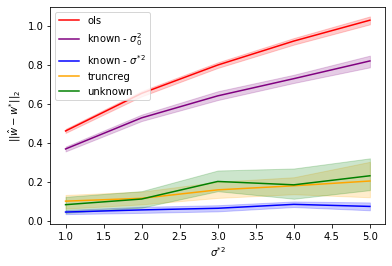

[Text(0, 0.5, '$|\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, '$\\sigma^{*2}$')]

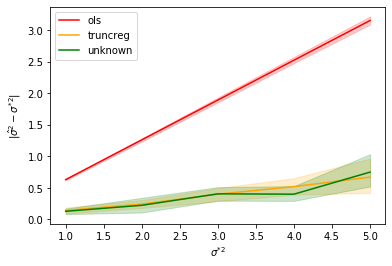

In [44]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='known - $\sigma_{0}^{2}$')
sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='known - $\sigma^{*2}$', color='blue')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='unknown', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')